# Climate Analysis

In [449]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import math
import numpy as np
import xarray as xr
import pandas as pd
from pandas.tseries.offsets import DateOffset
import netCDF4 as nc
import regionmask

from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import chisquare
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,plot_predict

In [10]:
# Load climate data
file = "C:/Users/21cen/Documents/Python/climate_analysis/gistemp.nc"
gistemp = xr.open_dataset(file)
mask = regionmask.defined_regions.srex.mask(gistemp)
time_ticks = gistemp.time.values.astype('datetime64[M]')

# For regionmask sorting
region_dict = {
    1: "Alaska/N.W. Canada",
    2: "Canada/Greenl./Icel.",
    3: "W. North America",
    4: "C. North America",
    5: "E. North America",
    6: "Central America/Mexico",
    7: "Amazon",
    8: "N.E. Brazil",
    9: "Coast South America",
    10: "S.E. South America",
    11: "N. Europe",
    12: "C. Europe",
    13: "S. Europe/Mediterranean",
    14: "Sahara",
    15: "W. Africa",
    16: "E. Africa",
    17: "S. Africa",
    18: "N. Asia",
    19: "W. Asia",
    20: "C. Asia",
    21: "Tibetan Plateau",
    22: "E. Asia",
    23: "S. Asia",
    24: "S.E. Asia",
    25: "N. Australia",
    26: "S. Australia/New Zealand"
}

region_range = {
    "North America": (1, 6),
    "South America": (7, 10),
    "Europe": (11, 13),
    "Africa": (14, 17),
    "Asia": (18, 24),
    "Australia": (25, 26)
}

## Regionmask of 26 regions

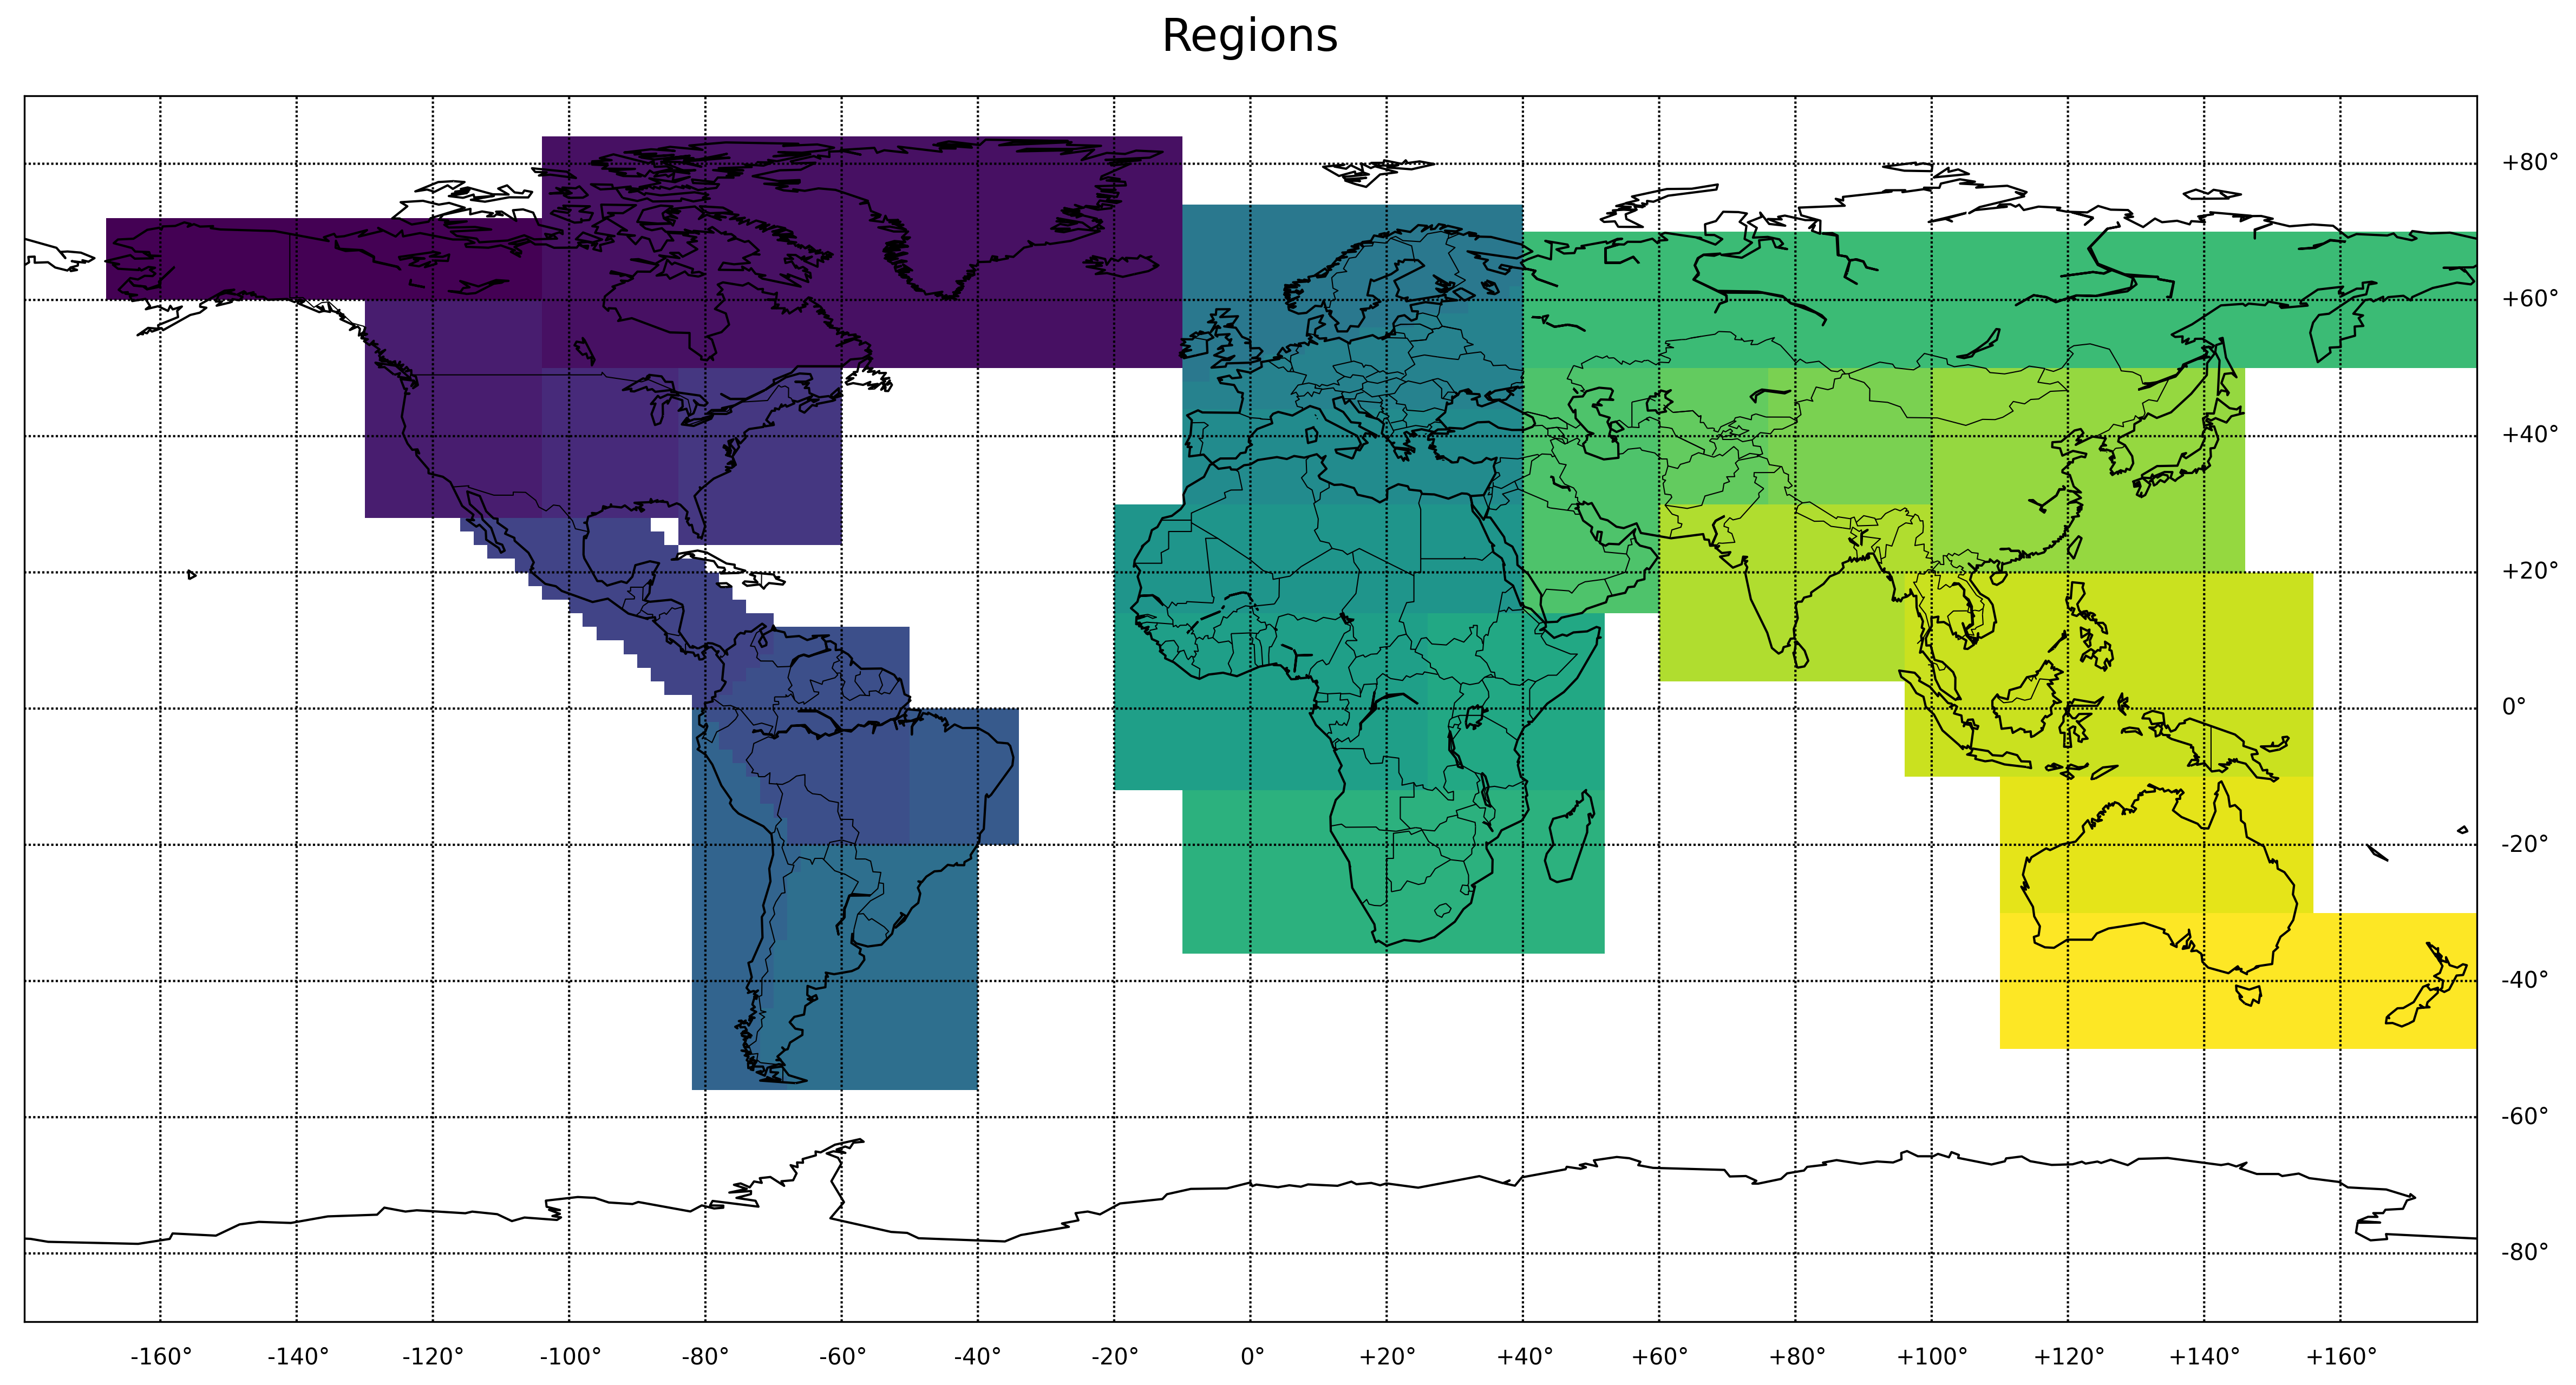

In [11]:
plt.figure(figsize=(20,10), facecolor='white')
map = Basemap()
map.drawcoastlines()
map.drawcountries()

lat = np.arange(-80, 81, 20)
lon = np.arange(-160, 161, 20)
map.drawparallels(lat, labels=[0, 1, 0, 0], labelstyle = "+/-")
map.drawmeridians(lon, labels=[0, 0, 0, 1], labelstyle = "+/-")
mask.plot(add_colorbar=False)
plt.title("Regions", fontsize = 20, pad = 20);
plt.xlabel("");
plt.ylabel("");

## Global Tempanomaly

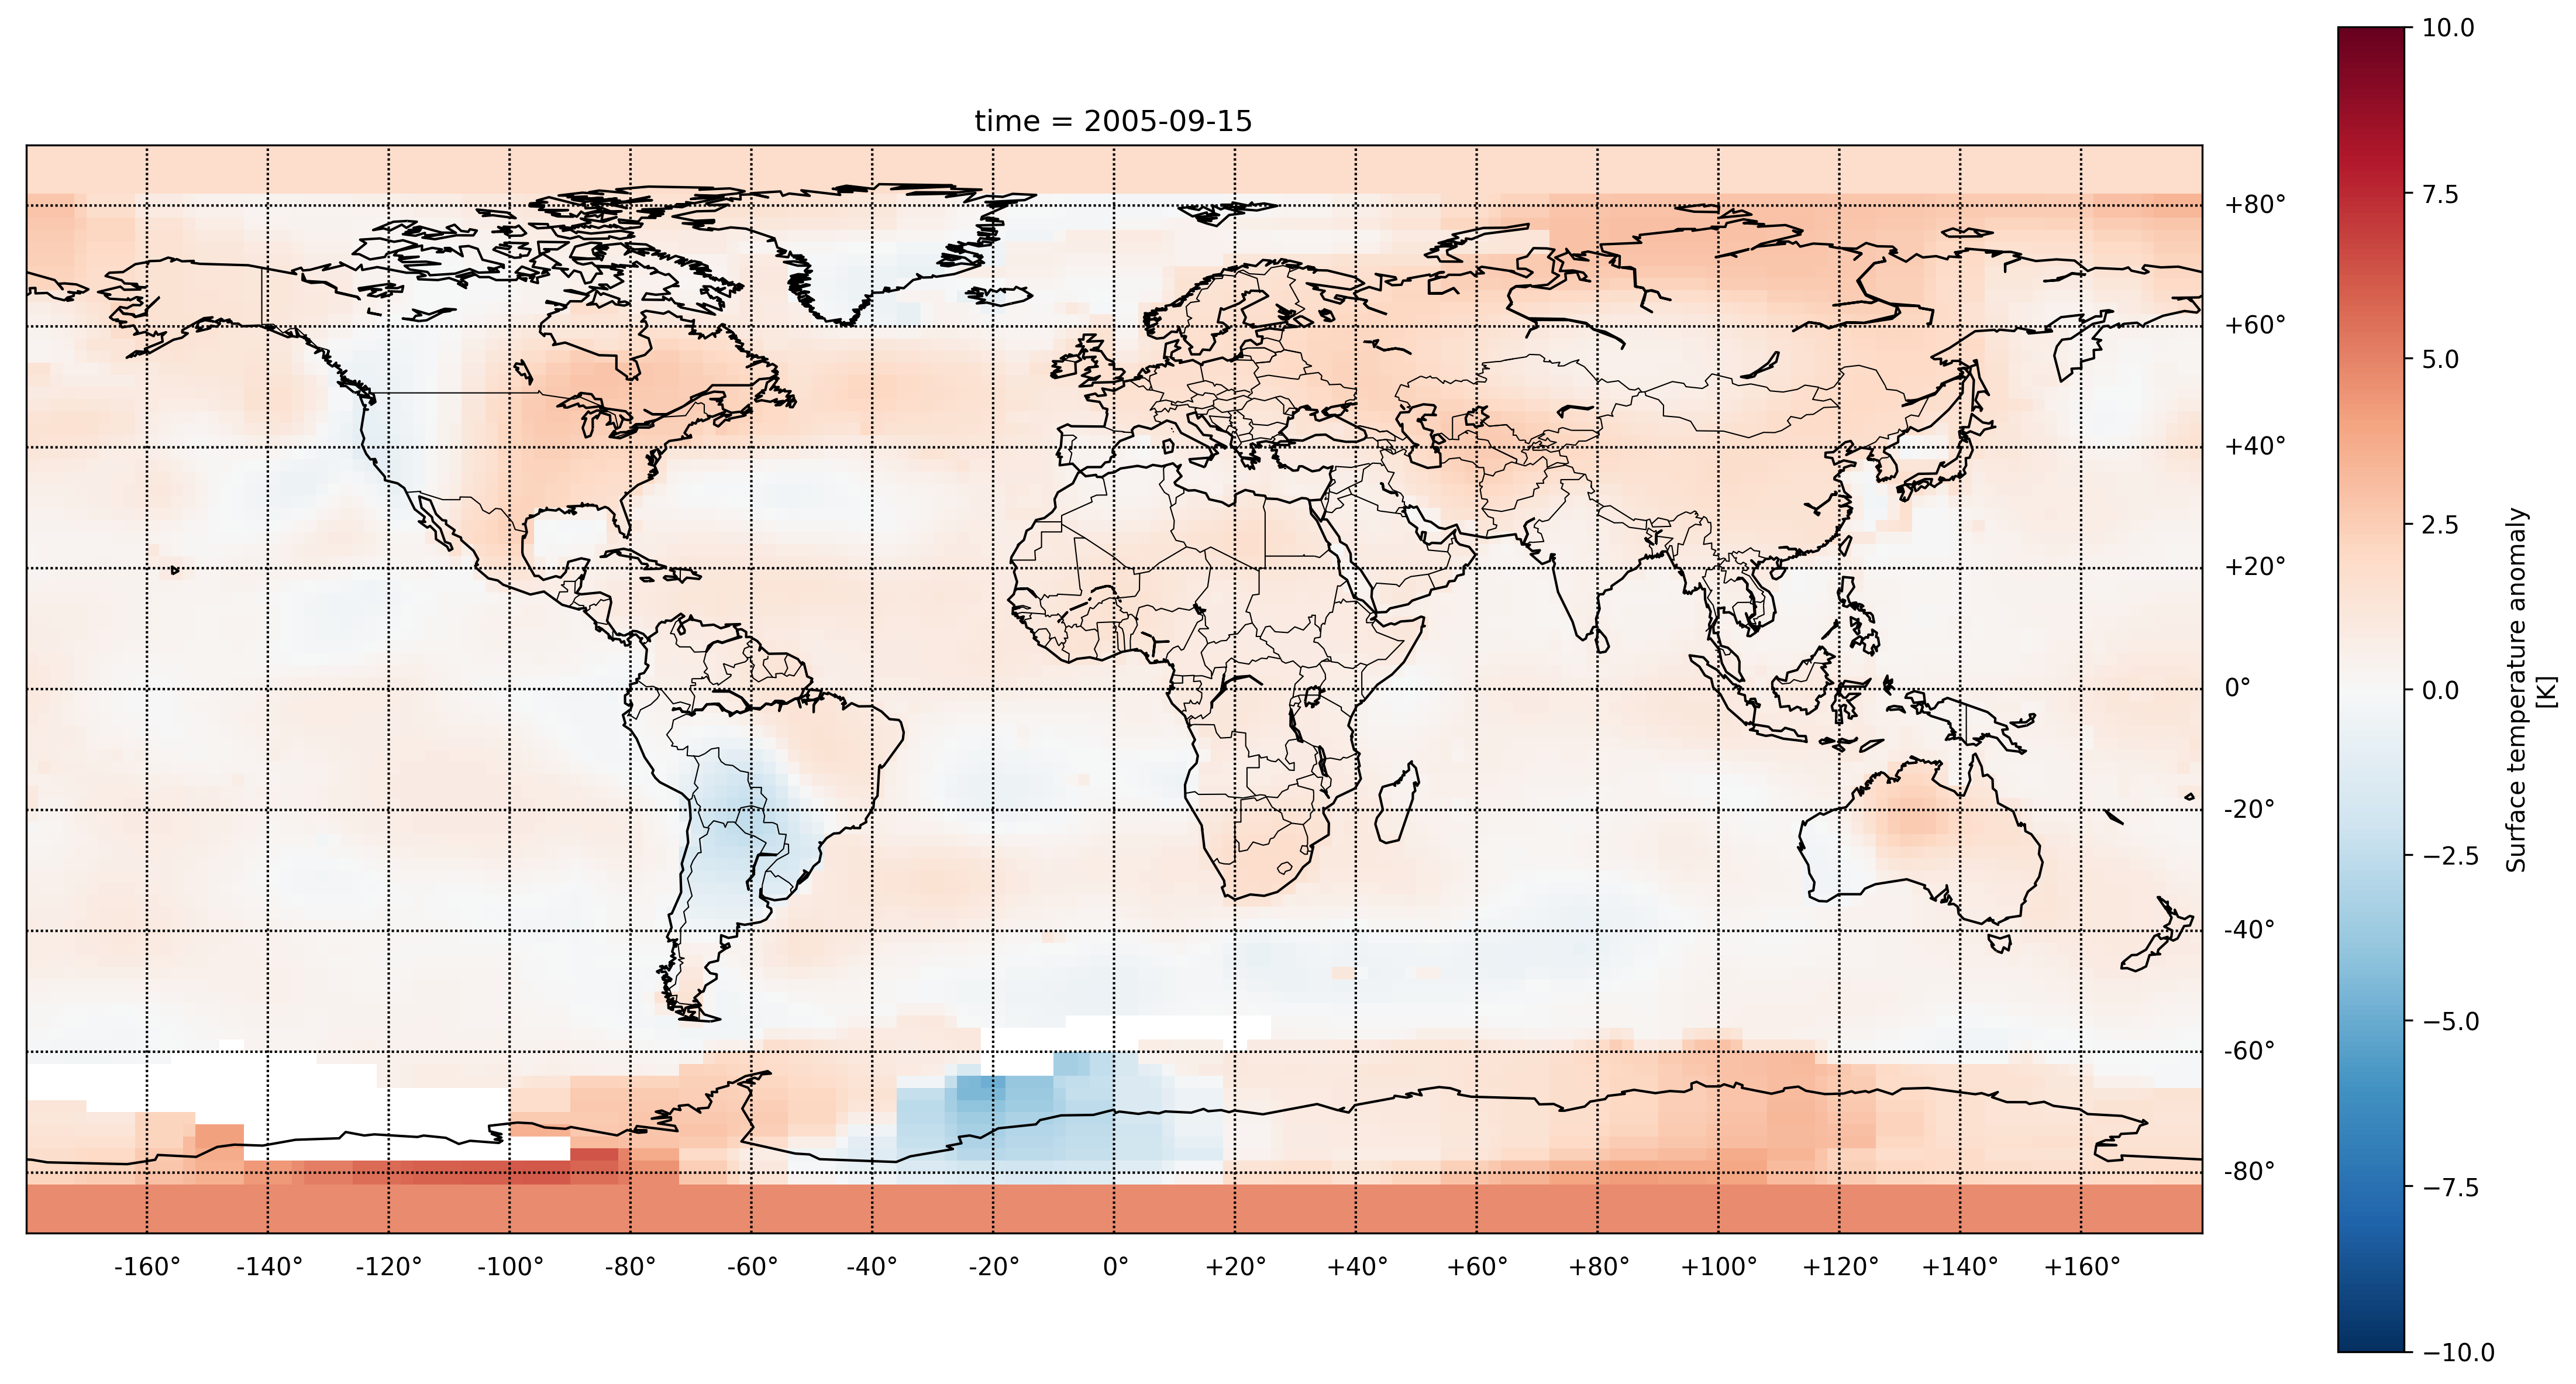

In [12]:
plt.figure(figsize=(20,10))
map = Basemap()
map.drawcoastlines()
map.drawcountries()
lat = np.arange(-80, 81, 20)
lon = np.arange(-160, 161, 20)
map.drawparallels(lat, labels=[0, 1, 0, 0], labelstyle = "+/-")
map.drawmeridians(lon, labels=[0, 0, 0, 1], labelstyle = "+/-")
gistemp.tempanomaly.isel(time = 1508).plot(cmap='RdBu_r', vmin = -10, vmax = 10);
plt.xlabel("");
plt.ylabel("");

## Ocean

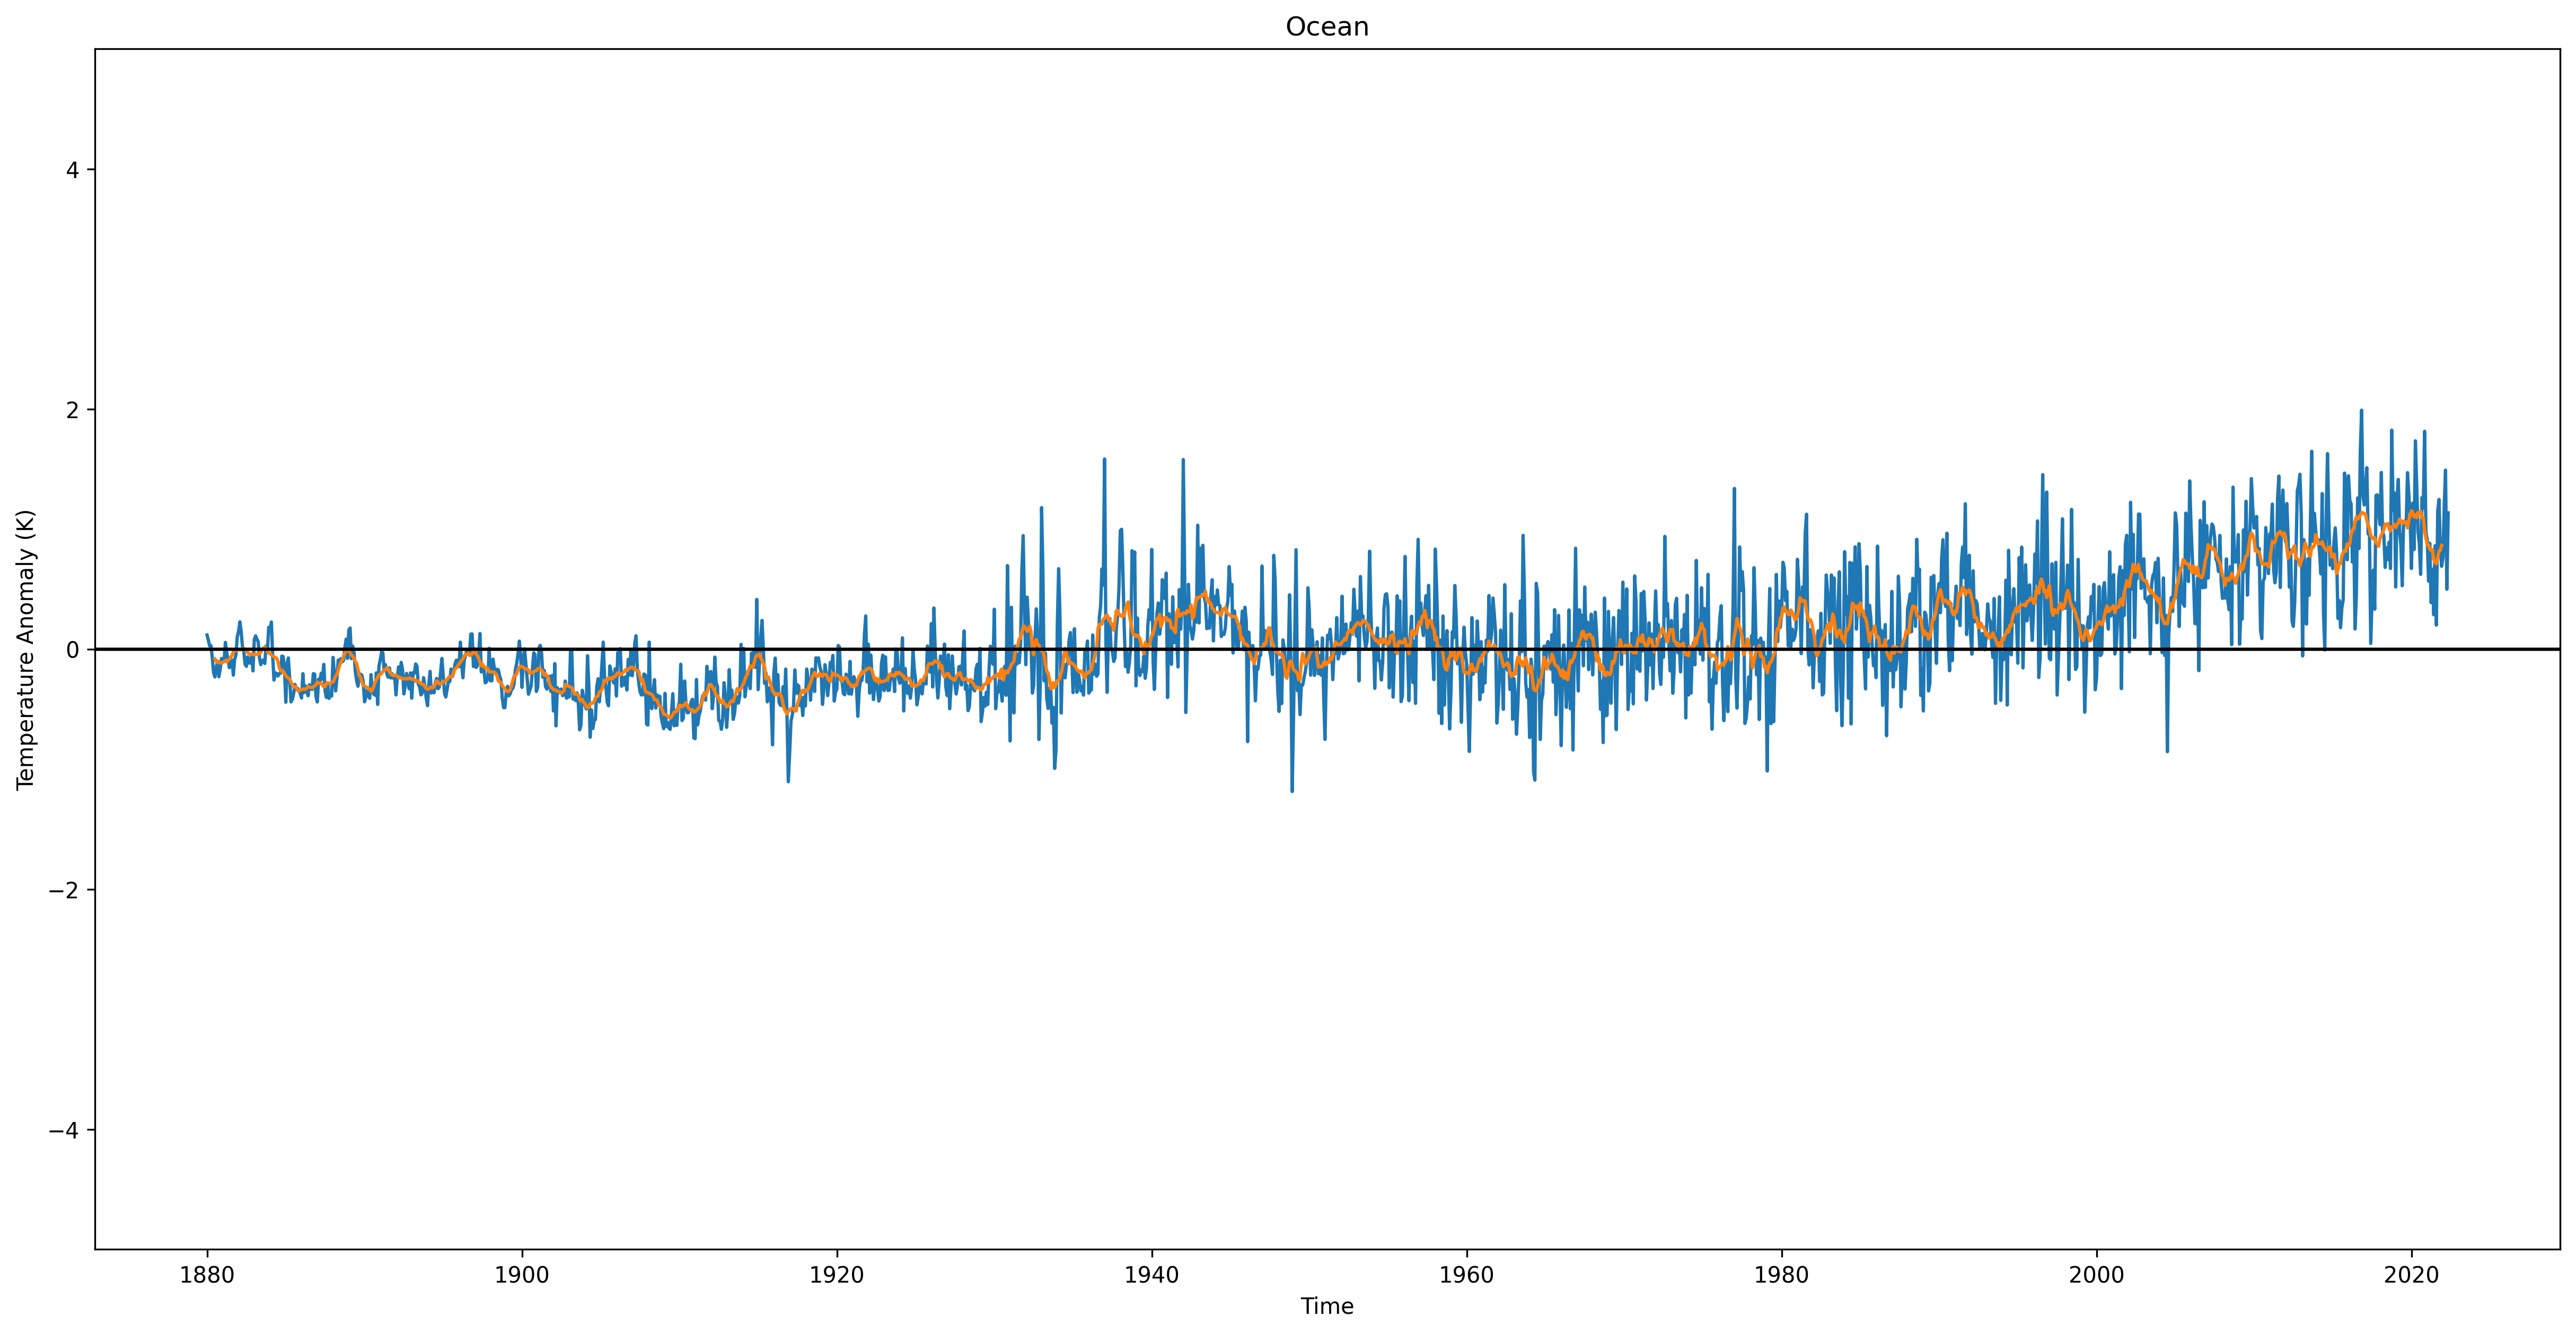

In [13]:
plt.figure(figsize=(20,10))
gistemp_region = gistemp.where(mask != mask)
x_ticks = gistemp.time.values.astype('datetime64[M]')

mean_anomaly = []
for itime in range(gistemp_region.time.size):
    mean_anomaly.append(float(gistemp_region.tempanomaly.isel(time = itime).mean()))
plt.plot(x_ticks, mean_anomaly)
plt.plot(x_ticks, pd.Series(mean_anomaly).rolling(window=12, center=True).mean())
plt.title("Ocean")
plt.ylim((-5, 5))
plt.xlabel("Time")
plt.ylabel("Temperature Anomaly (K)");
plt.axhline(y = 0, color = 'black')

## Tempanomaly by Continents

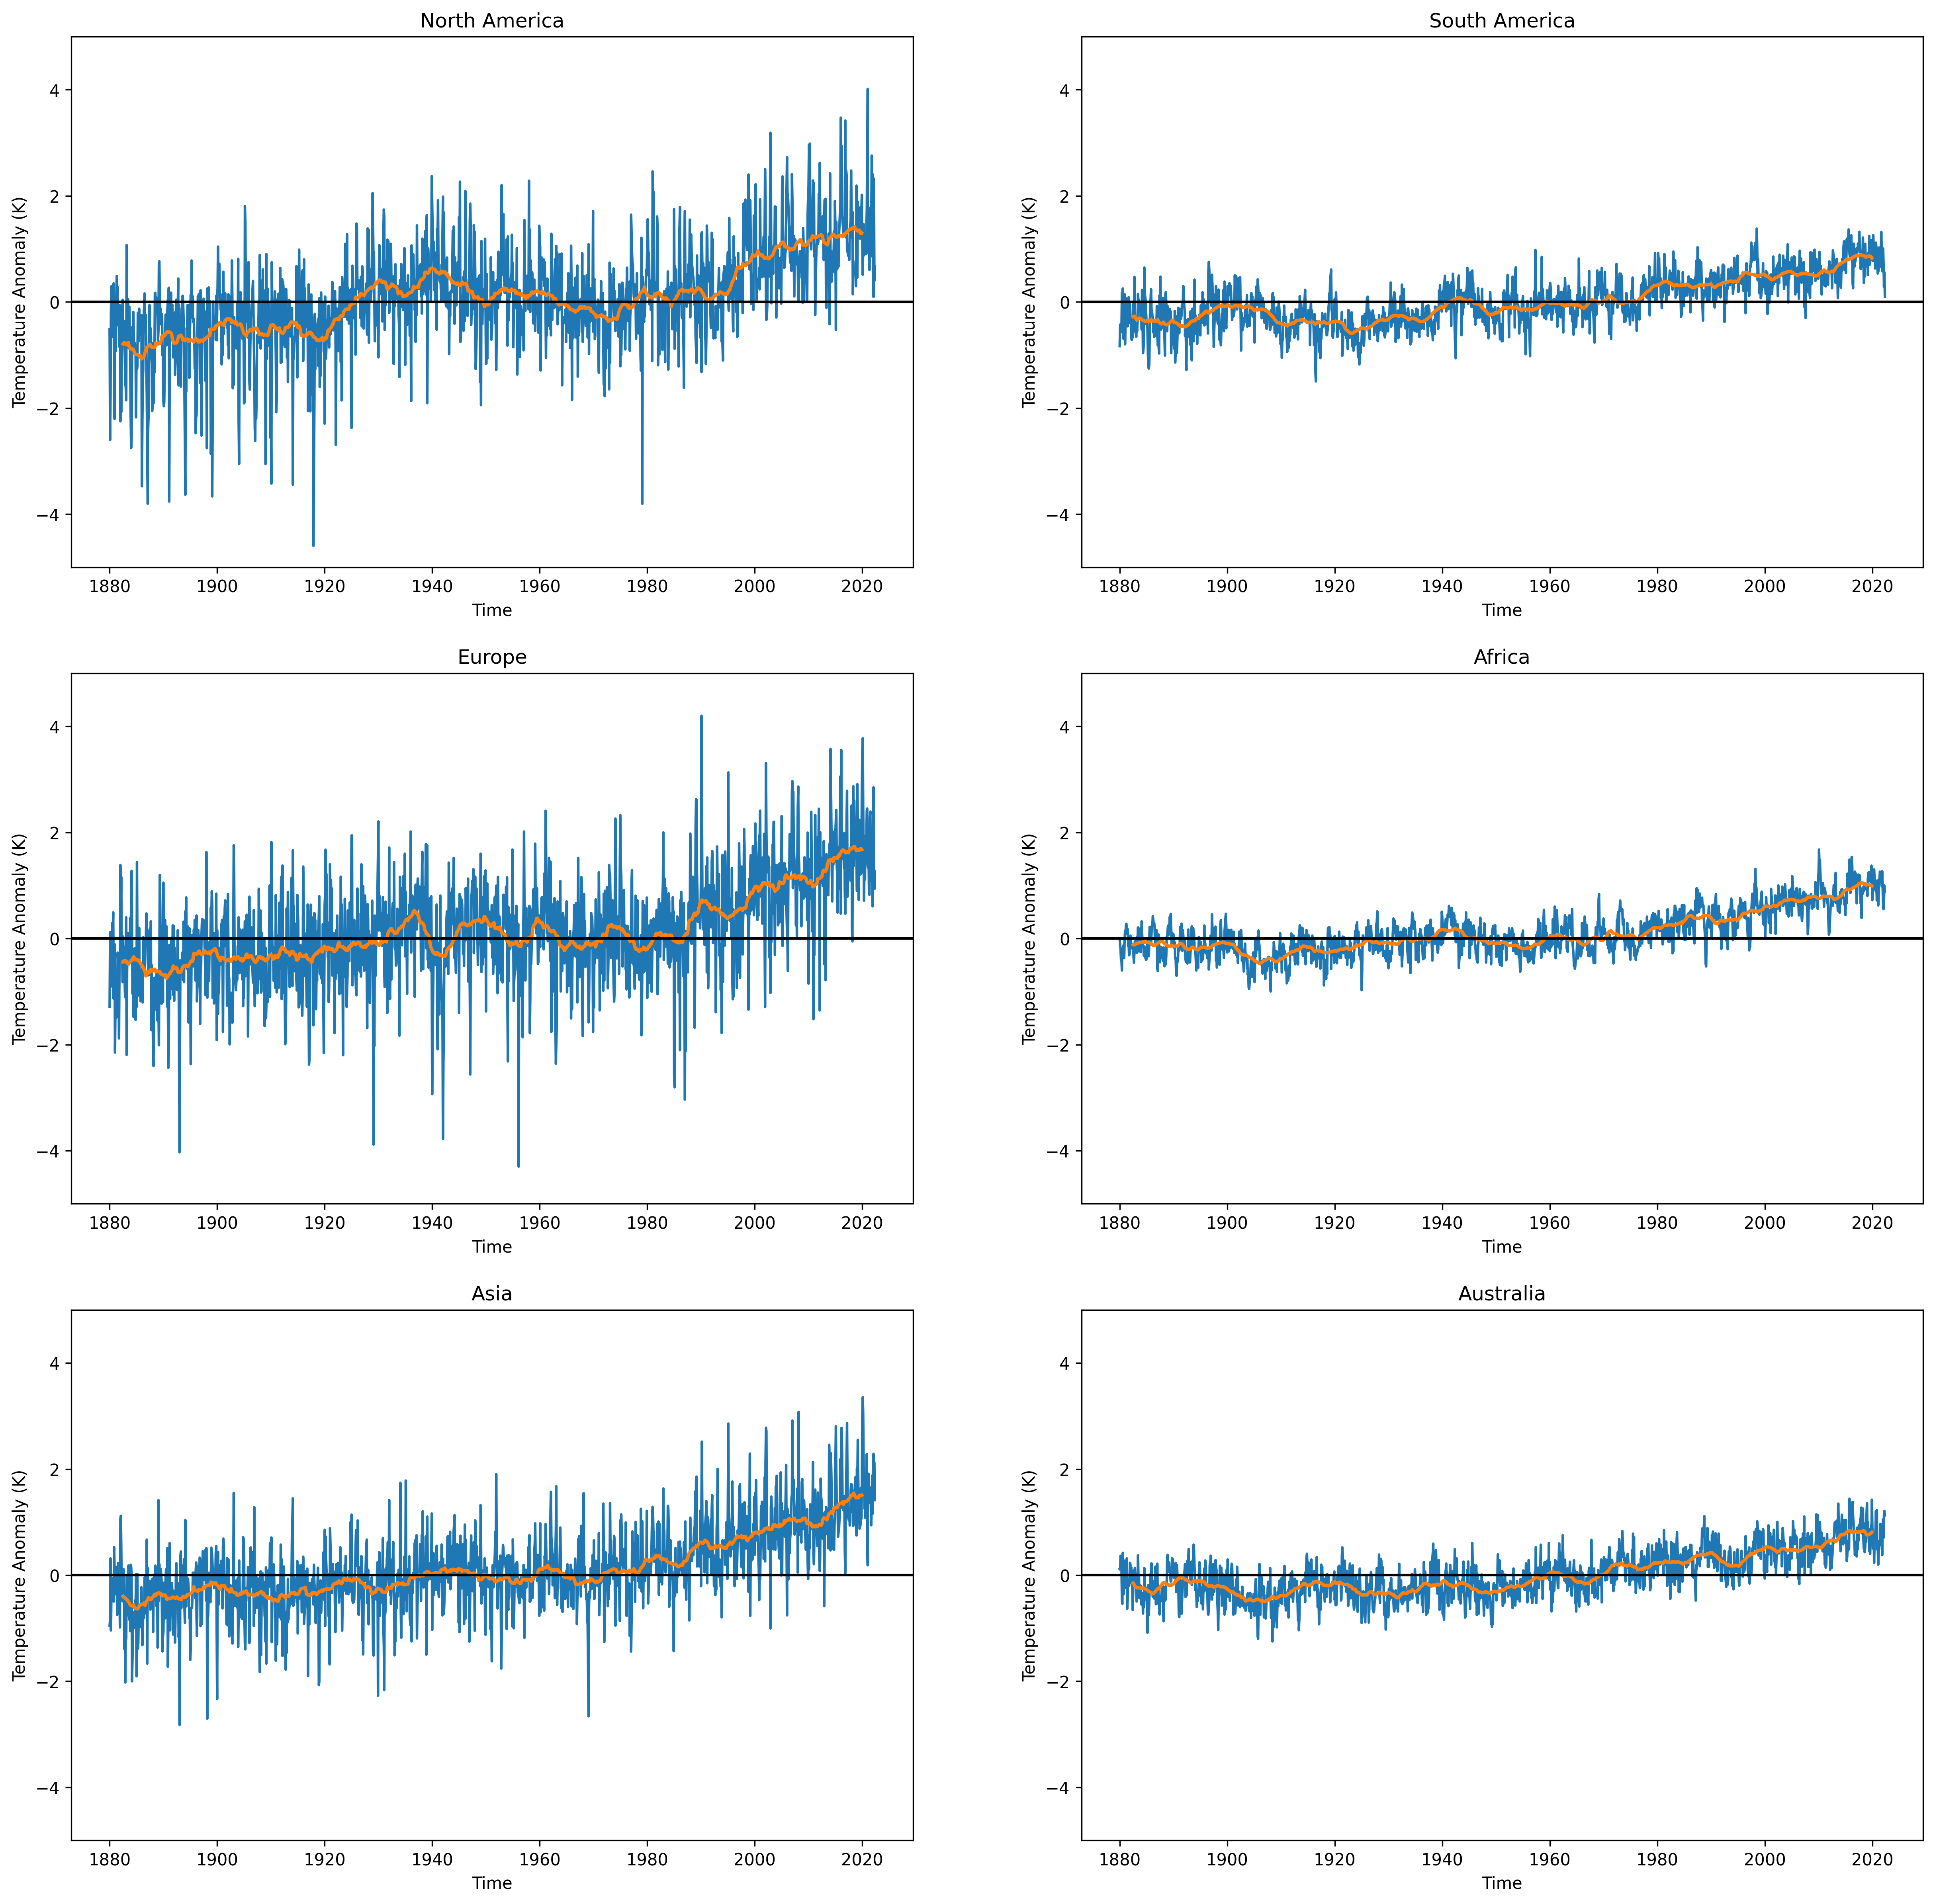

In [214]:
plt.figure(figsize=(20,20))

rolling_window = 60

for i in range(len(region_range)):
    region = list(region_range)[i]
    mean_anomaly = []
    mask_start = region_range[region][0]
    mask_end = region_range[region][1]
    gistemp_region = gistemp.where((mask >= mask_start) & (mask <= mask_end))
    for itime in range(gistemp_region.time.size):
        mean_anomaly.append(float(gistemp_region.tempanomaly.isel(time = itime).mean()))
    
    mean_anomaly = pd.Series(mean_anomaly, time_ticks)
    plt.subplot(3, 2, i + 1)
    plt.plot(mean_anomaly)
    plt.plot(mean_anomaly.rolling(window=rolling_window, center=True).mean(), linewidth=2)
    plt.title(region)
    plt.ylim((-5, 5))
    plt.xlabel("Time")
    plt.ylabel("Temperature Anomaly (K)");
    plt.axhline(y = 0, color = 'black')

## Tempanomaly by Regions

## Curve Fit

In [442]:
def r_squared(observed, predicted):
    return np.corrcoef(observed, predicted)[0,1] ** 2
def func6(x, a, b, c, d, e, f, g):
    return a * x**6 + b * x**5 + c * x**4 + d * x**3 + e * x**2 + f * x + g
def func5(x, a, b, c, d, e, f):
    return a * x**5 + b * x**4 + c * x**3 + d * x**2 + e * x + f
def func4(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e
def func3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d
def func2(x, a, b, c):
    return a * x**2 + b * x + c
def func1(x, a, b):
    return a * x + b

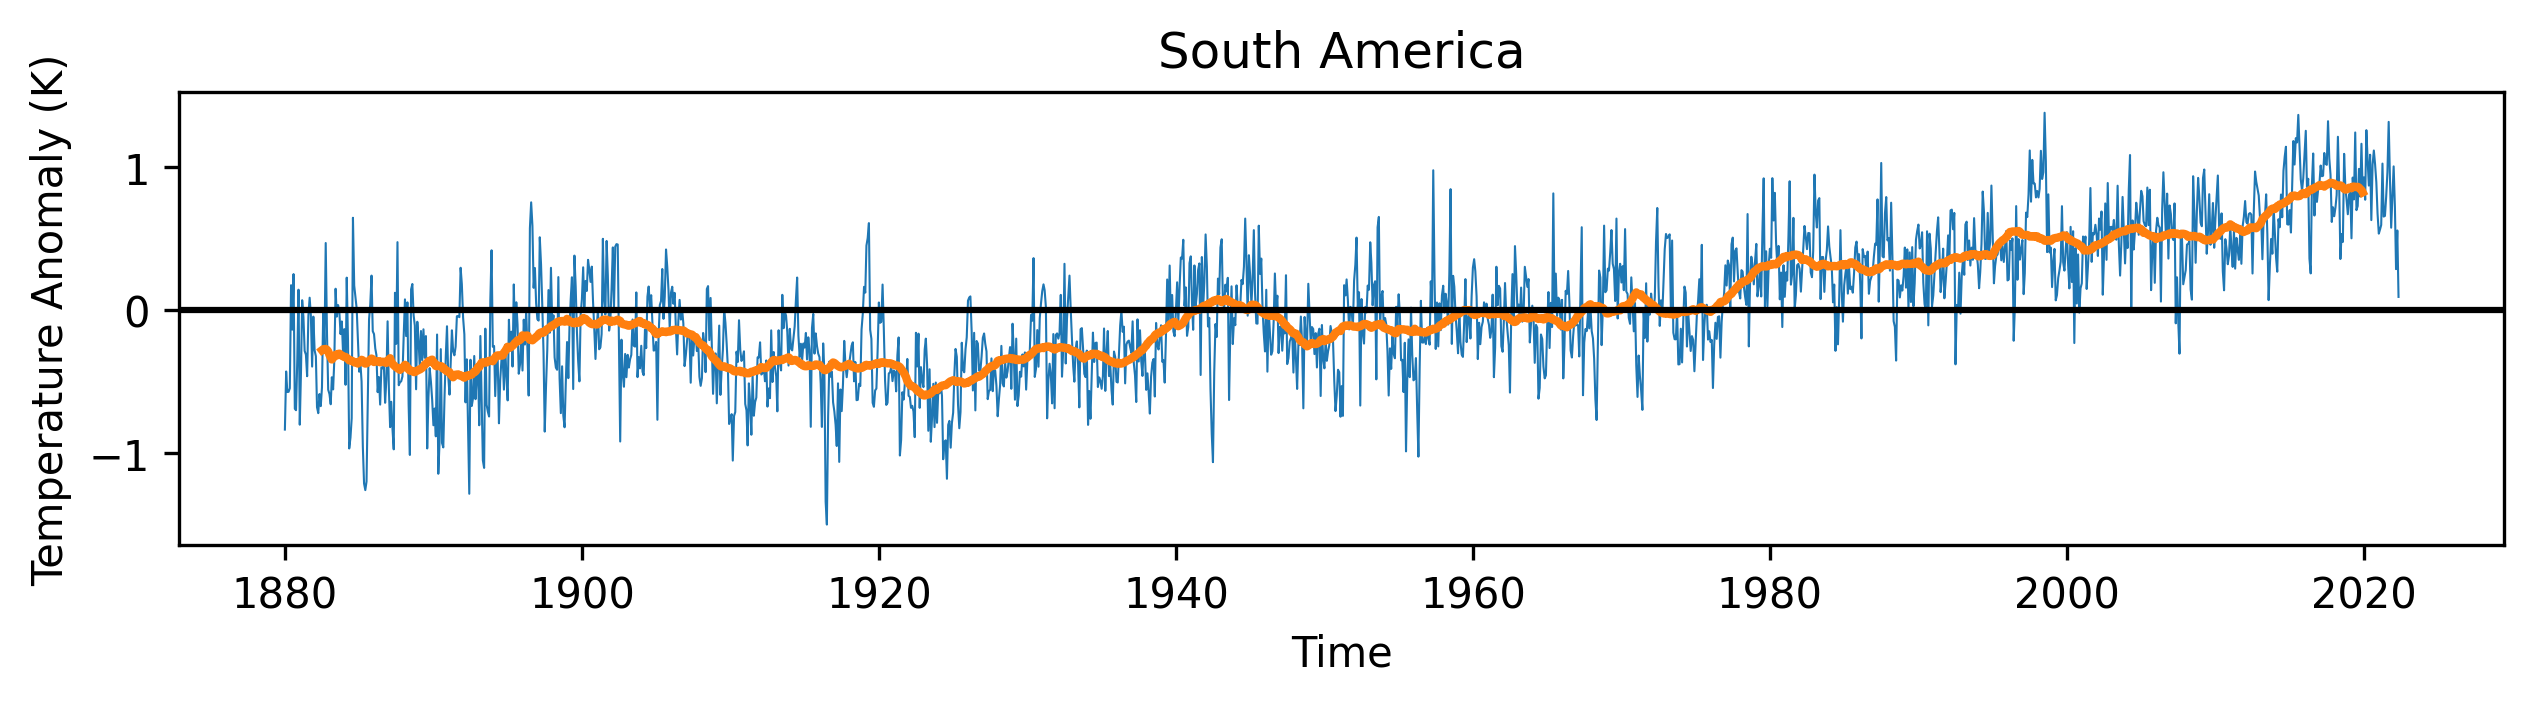

In [645]:
plt.figure(figsize=(10,2))
rolling_window = 60

region = list(region_range)[1]
mean_anomaly = []
mask_start = region_range[region][0]
mask_end = region_range[region][1]
gistemp_region = gistemp.where((mask >= mask_start) & (mask <= mask_end))
#gistemp_region = gistemp
for itime in range(gistemp_region.time.size):
    mean_anomaly.append(float(gistemp_region.tempanomaly.isel(time = itime).mean()))

mean_anomaly = pd.Series(mean_anomaly, time_ticks)
plt.plot(mean_anomaly, linewidth=0.5)
plt.plot(mean_anomaly.rolling(window=rolling_window, center=True).mean(), linewidth=2)
plt.title(region)
plt.xlabel("Time")
plt.ylabel("Temperature Anomaly (K)");
plt.axhline(y = 0, color = 'black')

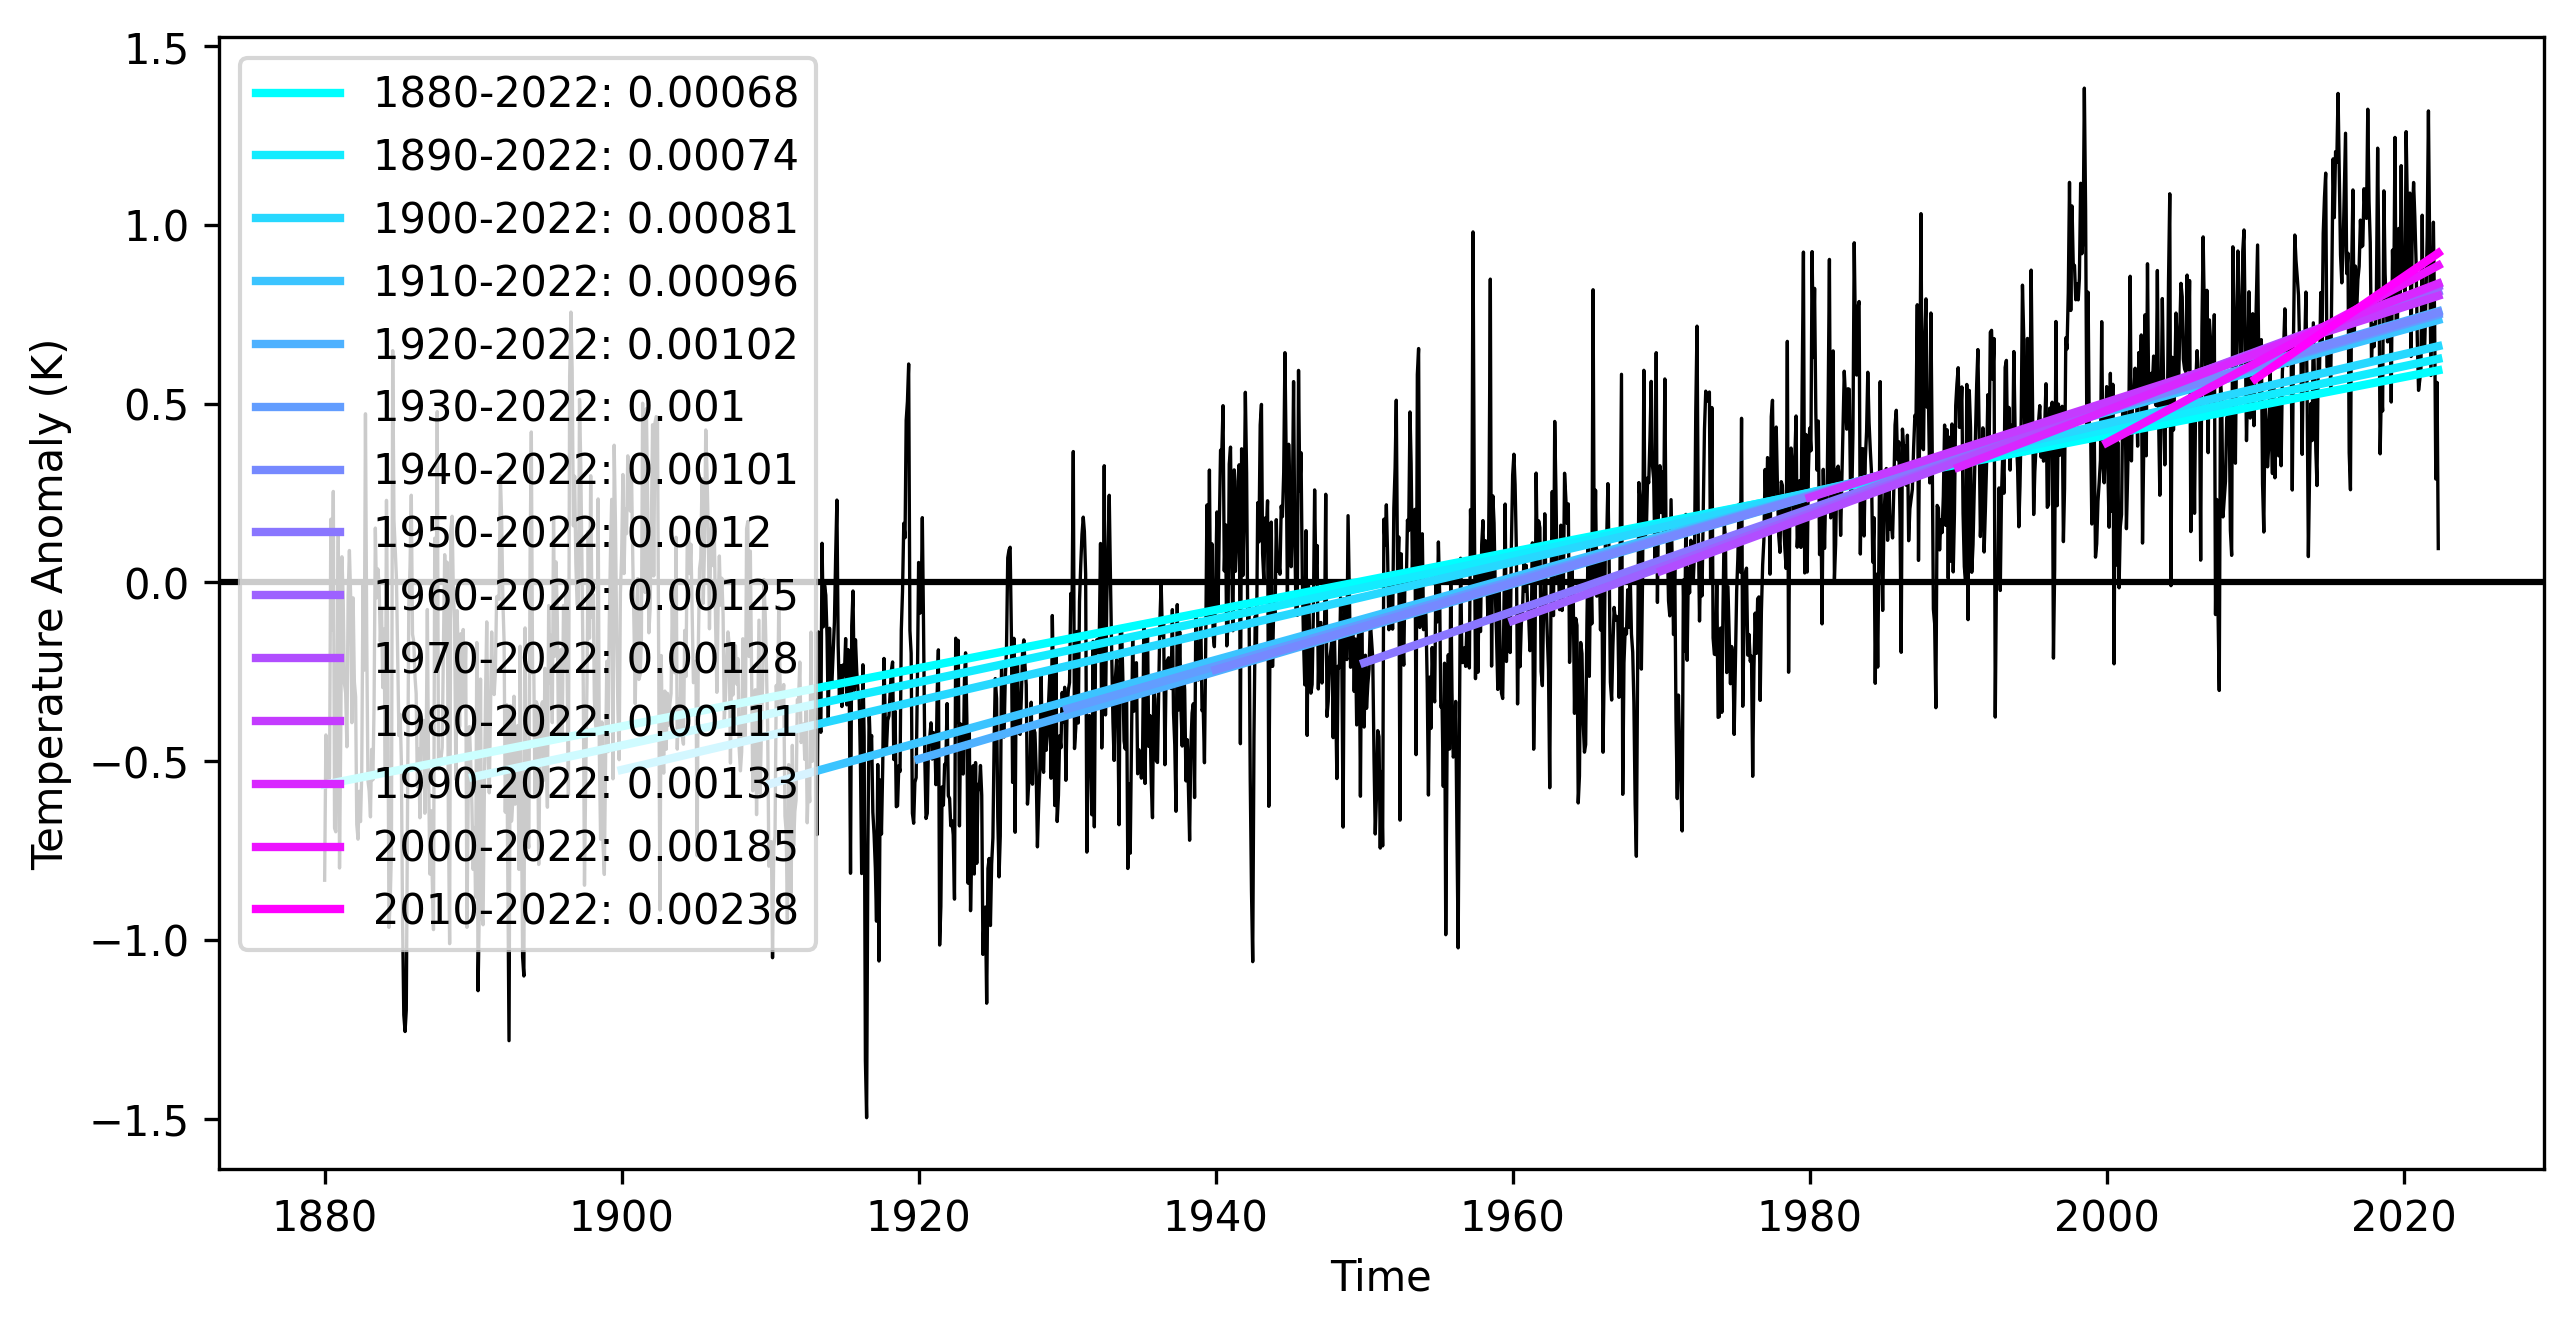

In [646]:
curve_fit_func = func2
regression_window = 120

plt.figure(figsize=(10, 5))
x = np.arange(float(mean_anomaly.size))
cmap = plt.get_cmap('cool')
colors = [cmap(i) for i in np.linspace(0, 1, int(mean_anomaly.size / regression_window))]
plt.plot(mean_anomaly, linewidth = 0.8, color='black')
plt.xlabel("Time")
plt.ylabel("Temperature Anomaly (K)");
plt.axhline(y = 0, color = 'black')

temp_rate = []
rate_label = []

for i in range(int(mean_anomaly.size / regression_window)):
    popt, pcov = curve_fit(func1, x[i*regression_window:], mean_anomaly[i*regression_window:])
    line_label = str(np.datetime64(temp_ticks[i*regression_window], 'Y')) + "-2022: " + str(round(popt[0], 5))
    plt.plot(time_ticks[i*regression_window:], func1(x, *popt)[i*regression_window:], linewidth=2, color=colors[i], label=line_label)
    temp_rate.append(popt[0])
    rate_label.append(str(np.datetime64(temp_ticks[i*regression_window], 'Y')))

#popt, pcov = curve_fit(curve_fit_func, x, mean_anomaly)
#plt.plot(temp_ticks, curve_fit_func(x, *popt), color='black')
plt.legend()

Text(0.5, 1.0, 'South America')

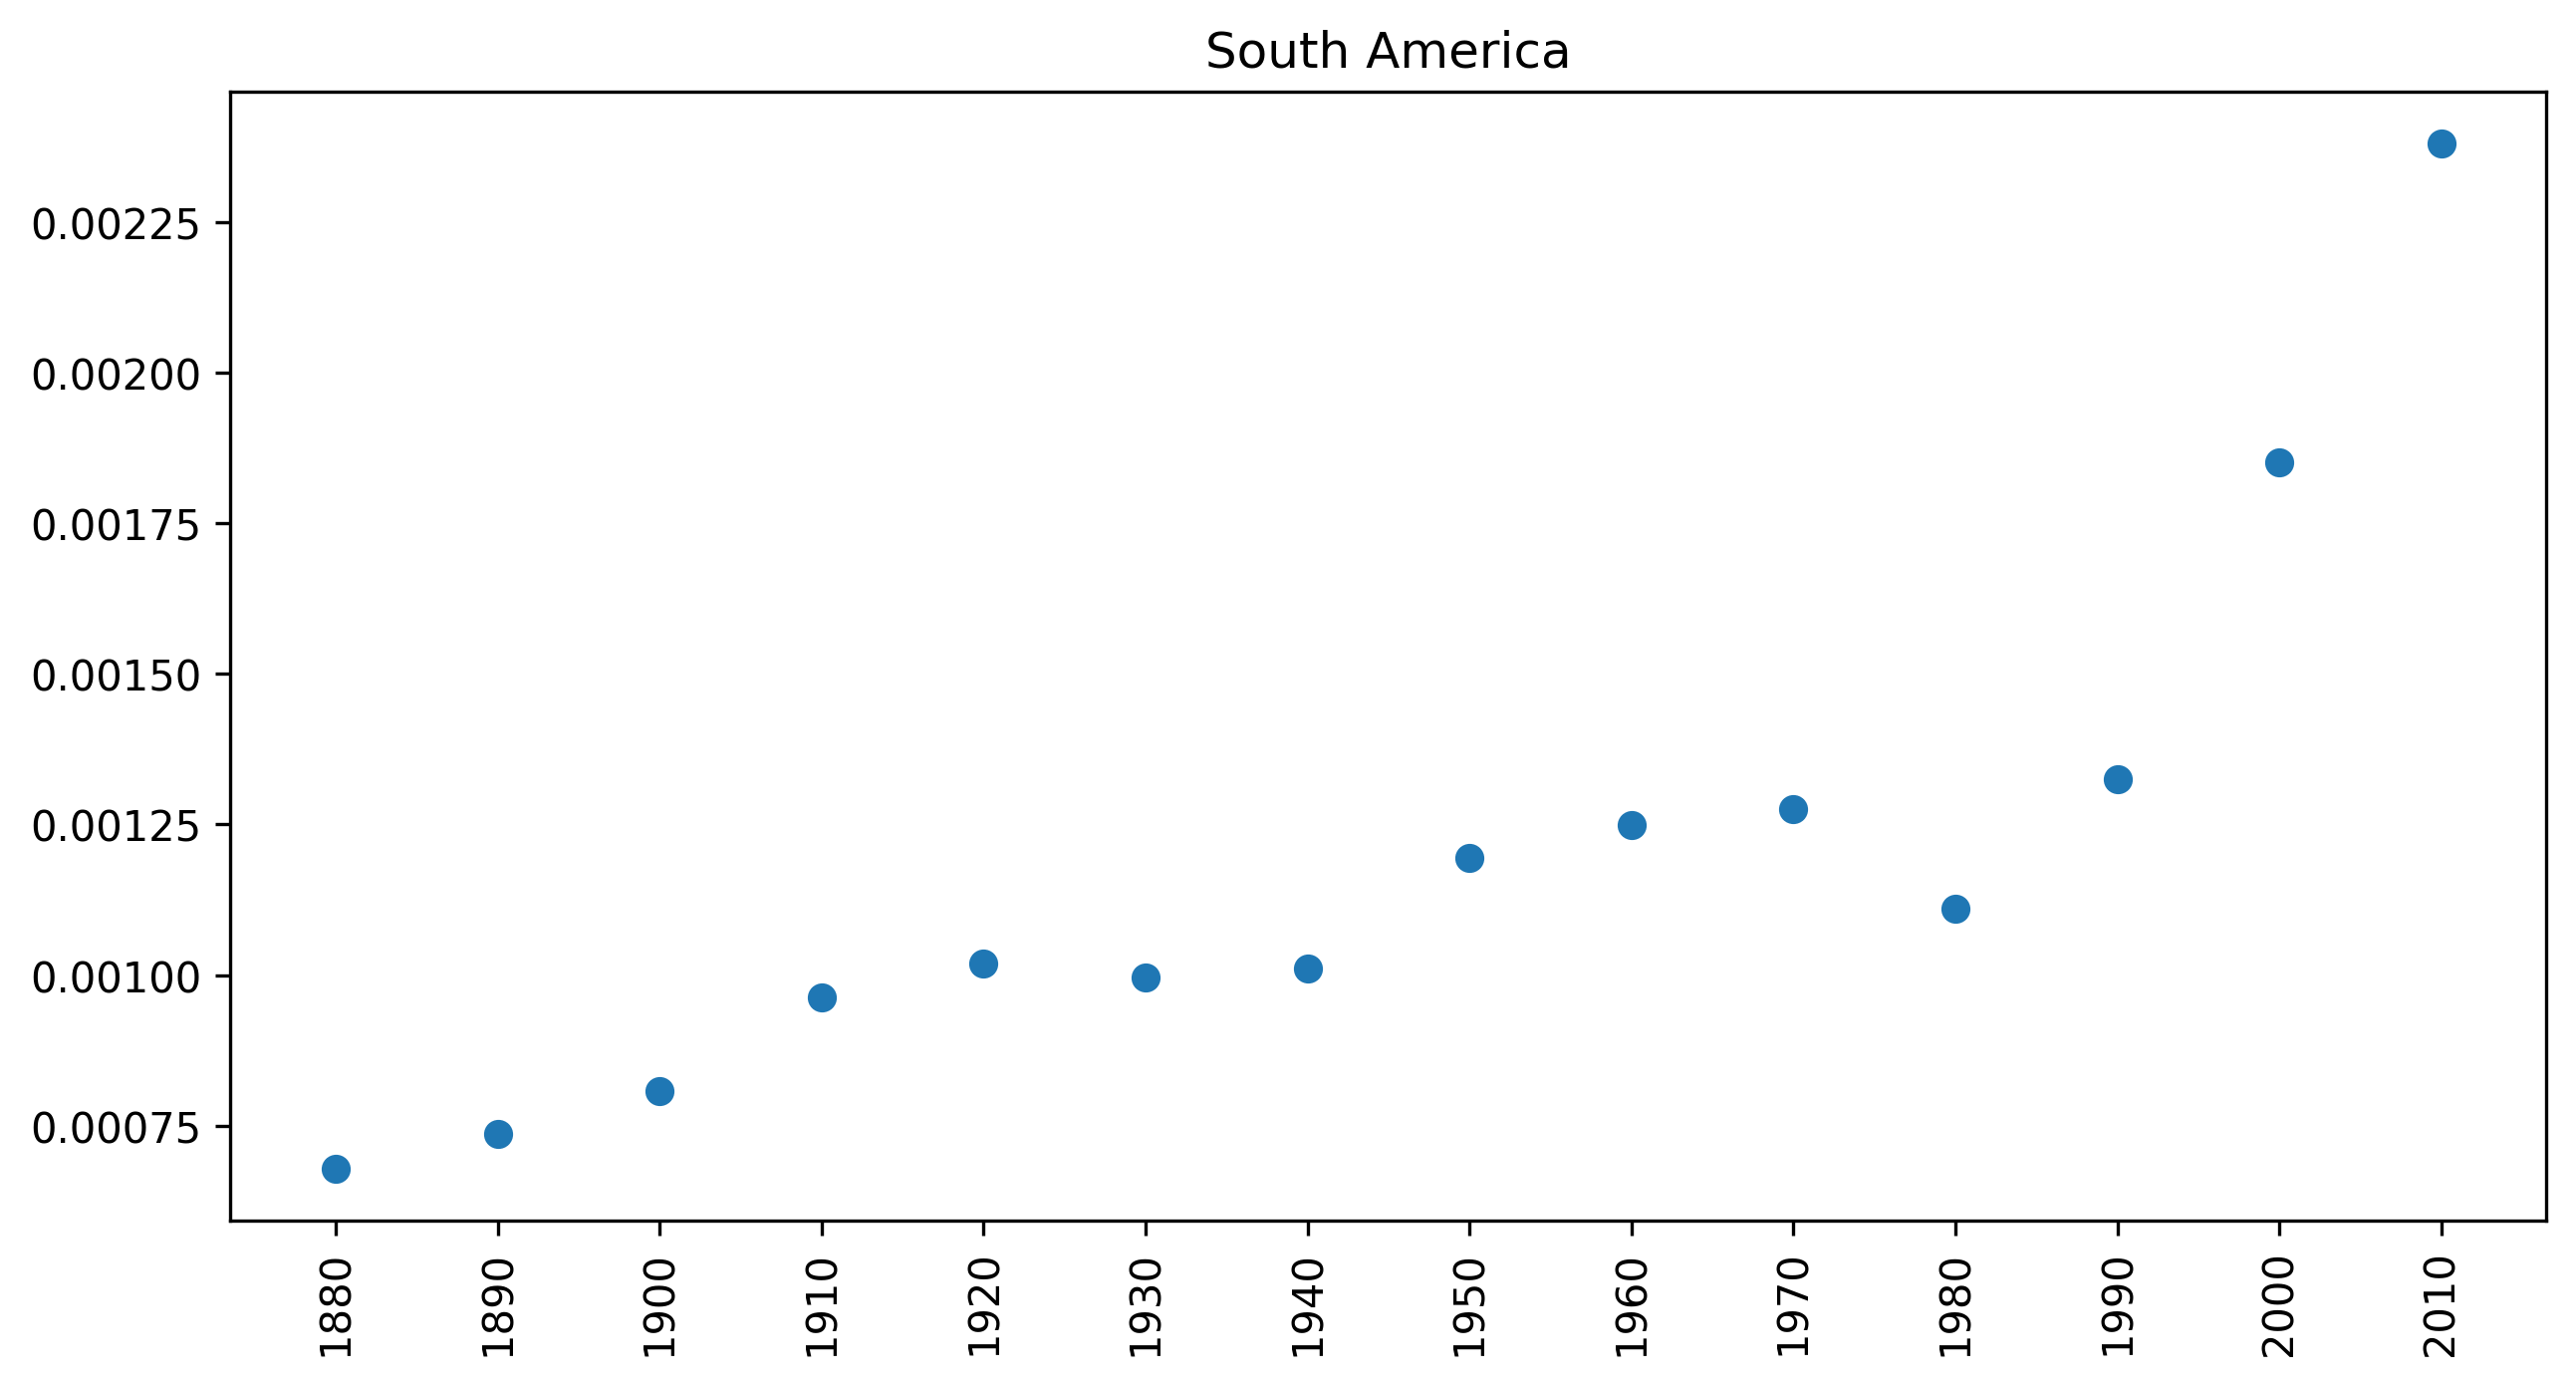

In [647]:
plt.figure(figsize=(10, 5))
plt.scatter(rate_label, temp_rate)
plt.xticks(rotation=90);
plt.title(region)

Tempanomaly in 20 years: 1.9997976979202898 (K)


0.5773066995251209

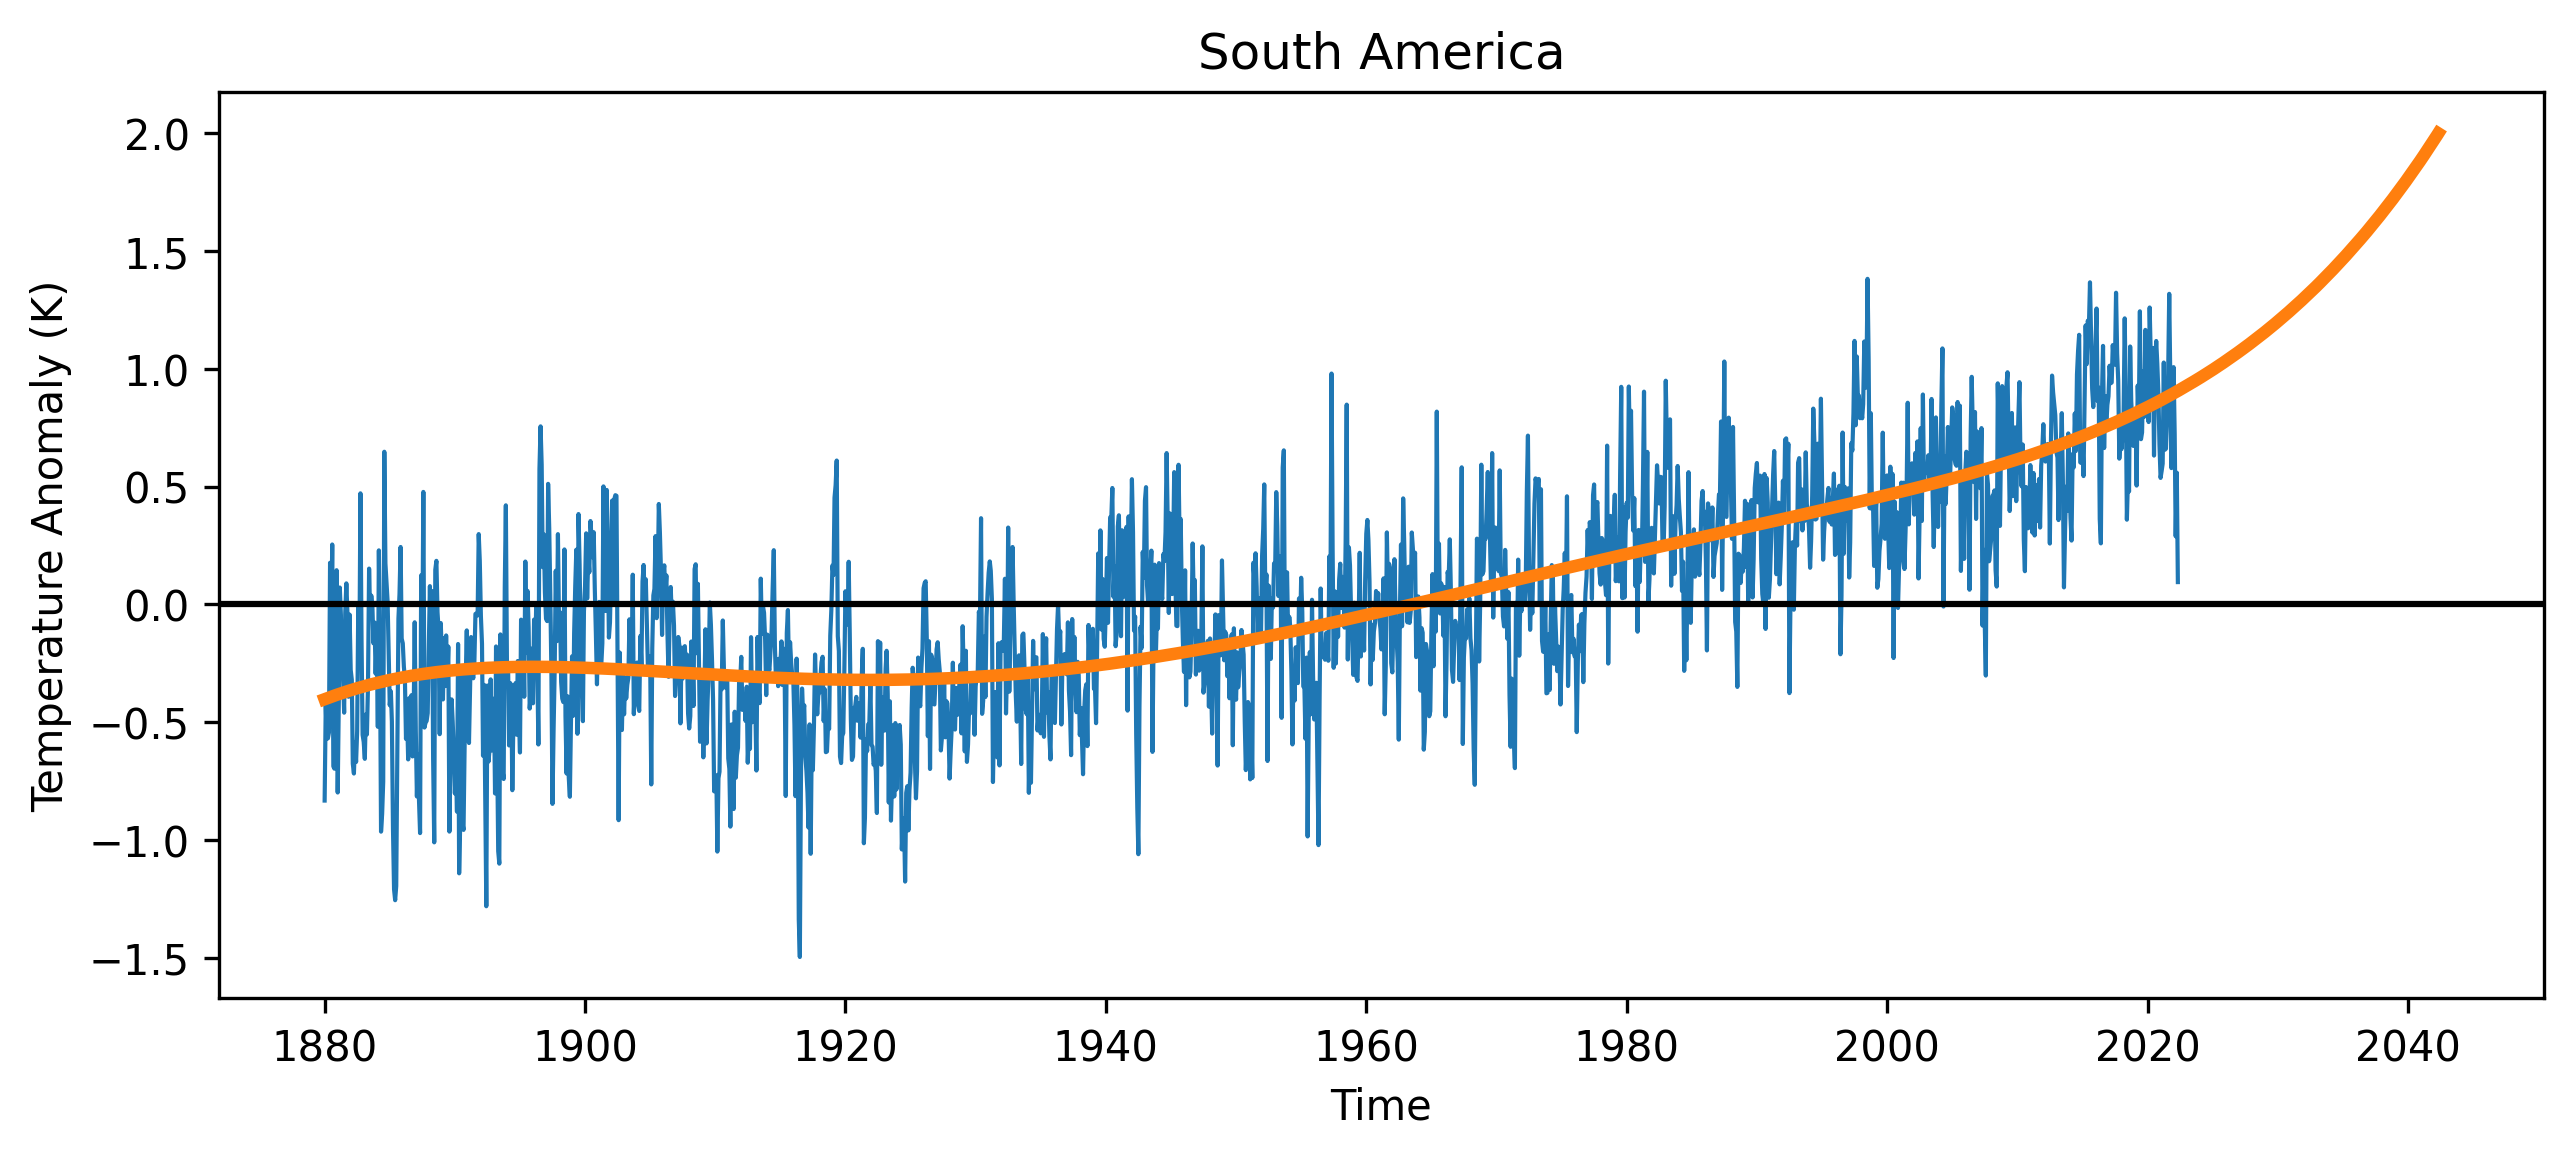

In [648]:
curve_fit_func = func5
plt.figure(figsize=(10,4))
predict_years = 20

x = np.arange(float(mean_anomaly.size))
temp_ticks = time_ticks
for i in range (predict_years * 12):
    temp_ticks = np.append(temp_ticks, temp_ticks[-1:] + 1)
extended_x = np.arange(float(mean_anomaly.size + predict_years * 12))

popt, pcov = curve_fit(curve_fit_func, x, mean_anomaly)
plt.title(region)
plt.plot(mean_anomaly.keys(), mean_anomaly, linewidth=1)
plt.plot(temp_ticks, curve_fit_func(extended_x, *popt), linewidth=3)
#plt.ylim((-5, 5))
plt.xlabel("Time")
plt.ylabel("Temperature Anomaly (K)");
plt.axhline(y = 0, color = 'black')
print("Tempanomaly in " + str(predict_years) + " years: " + str(curve_fit_func(1708+predict_years*12, *popt)) + " (K)")
r_squared(mean_anomaly, curve_fit_func(x, *popt))

## ARIMA

In [15]:
def test_stationarity(timeseries, rolling_window):
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(rolling_window).mean()
    rolstd = pd.Series(timeseries).rolling(rolling_window).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [143]:
region = list(region_range)[1]
mean_anomaly = []
mask_start = region_range[region][0]
mask_end = region_range[region][1]
gistemp_region = gistemp.where((mask >= mask_start) & (mask <= mask_end))
for itime in range(gistemp_region.time.size):
    mean_anomaly.append(float(gistemp_region.tempanomaly.isel(time = itime).mean()))
mean_anomaly_pd = pd.Series(data = mean_anomaly, index = time_ticks)

rolling_window = 12
# moving average
moving_avg = mean_anomaly_pd.rolling(rolling_window).mean()
moving_avg_diff = mean_anomaly_pd - moving_avg
moving_avg_diff.dropna(inplace=True)
# exponentially weighted moving average
ewm_avg = mean_anomaly_pd.ewm(rolling_window).mean()
ewm_diff = mean_anomaly_pd - ewm_avg
ewm_diff.dropna(inplace=True)
# differencing
first_diff = mean_anomaly_pd - mean_anomaly_pd.shift(1)
first_diff.dropna(inplace=True)
seasonal_diff = mean_anomaly_pd - mean_anomaly_pd.shift(12)
seasonal_diff.dropna(inplace=True)
# decomposing
decomposition = seasonal_decompose(mean_anomaly_pd)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
residual.dropna(inplace=True)

C:\Users\21cen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


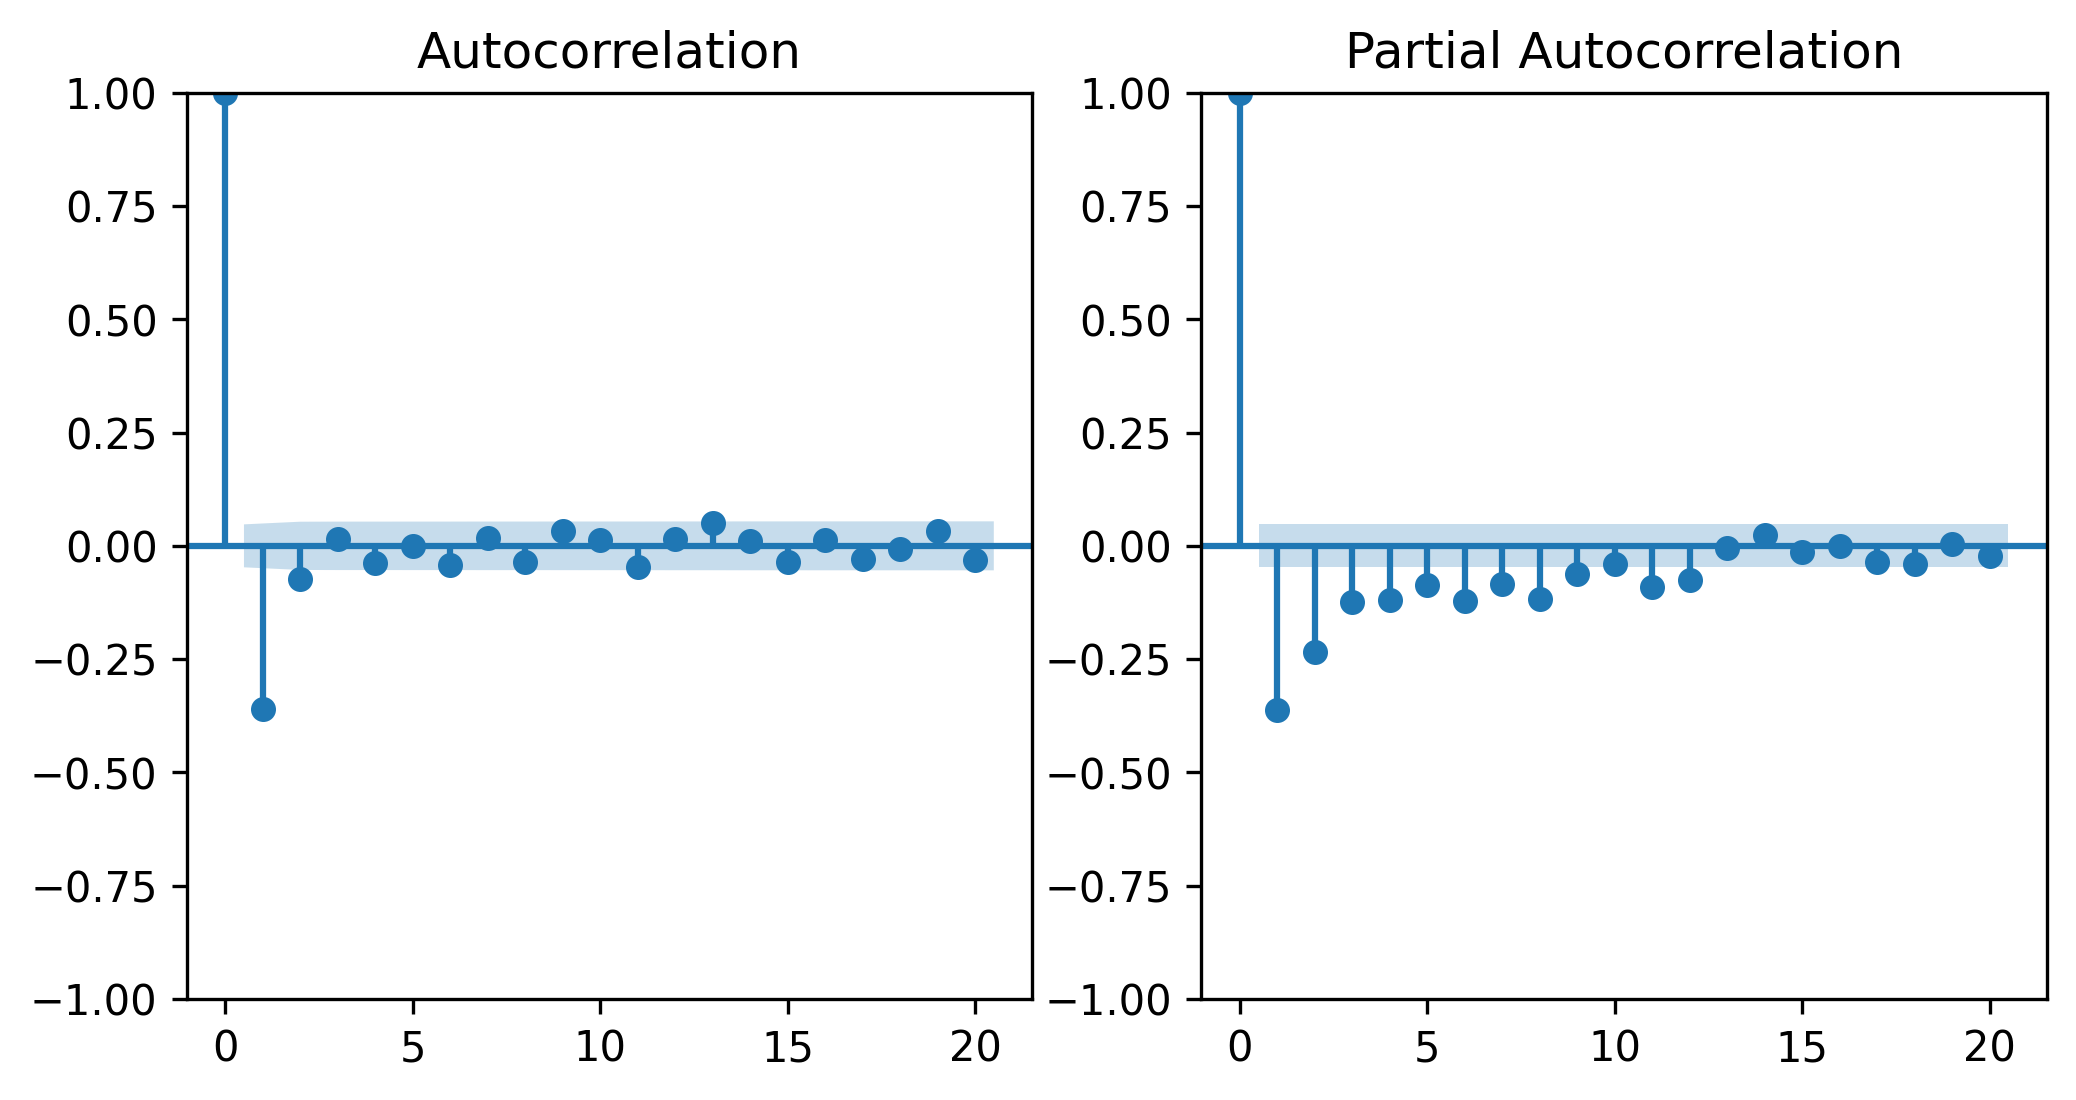

In [180]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
fig = plot_acf(first_diff,lags=20,ax=ax1)
ax2 = fig.add_subplot(122)
fig = plot_pacf(first_diff,lags=20,ax=ax2)

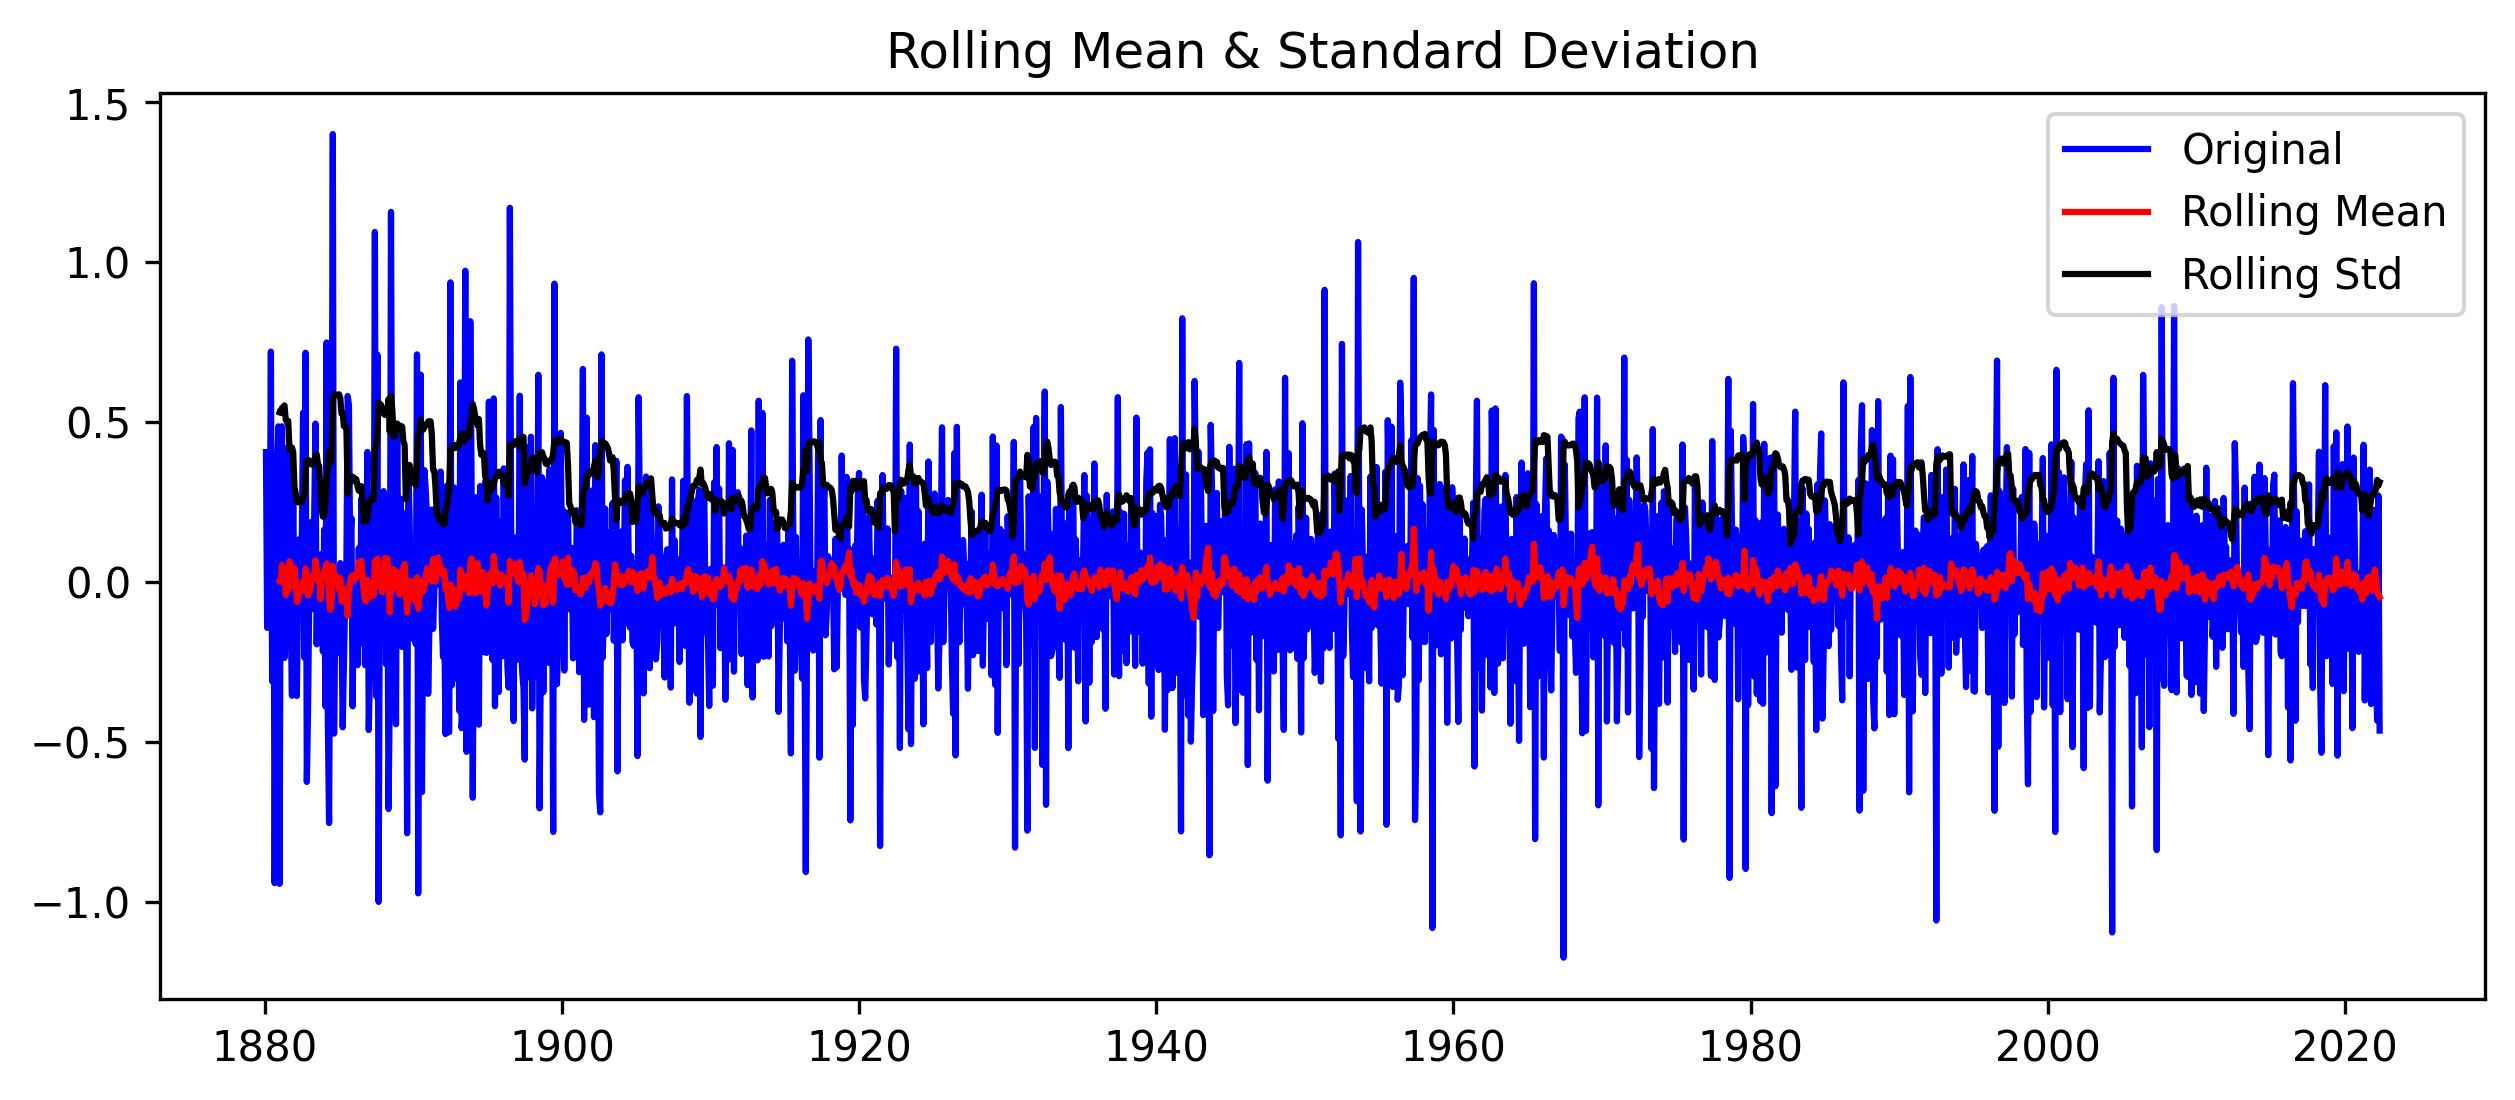

Results of Dickey-Fuller Test:
Test Statistic                  -18.976032
p-value                           0.000000
#Lags Used                       11.000000
Number of Observations Used    1696.000000
Critical Value (1%)              -3.434212
Critical Value (5%)              -2.863246
Critical Value (10%)             -2.567678
dtype: float64


In [167]:
# stationarity test
plt.figure(figsize=(10,4))
test_stationarity(first_diff, 12)

In [206]:
SARIMA_model=sm.tsa.statespace.SARIMAX(mean_anomaly_pd,order=(2, 1, 2),seasonal_order=(2,1,2,12))
results=SARIMA_model.fit()

C:\Users\21cen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\21cen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\21cen\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


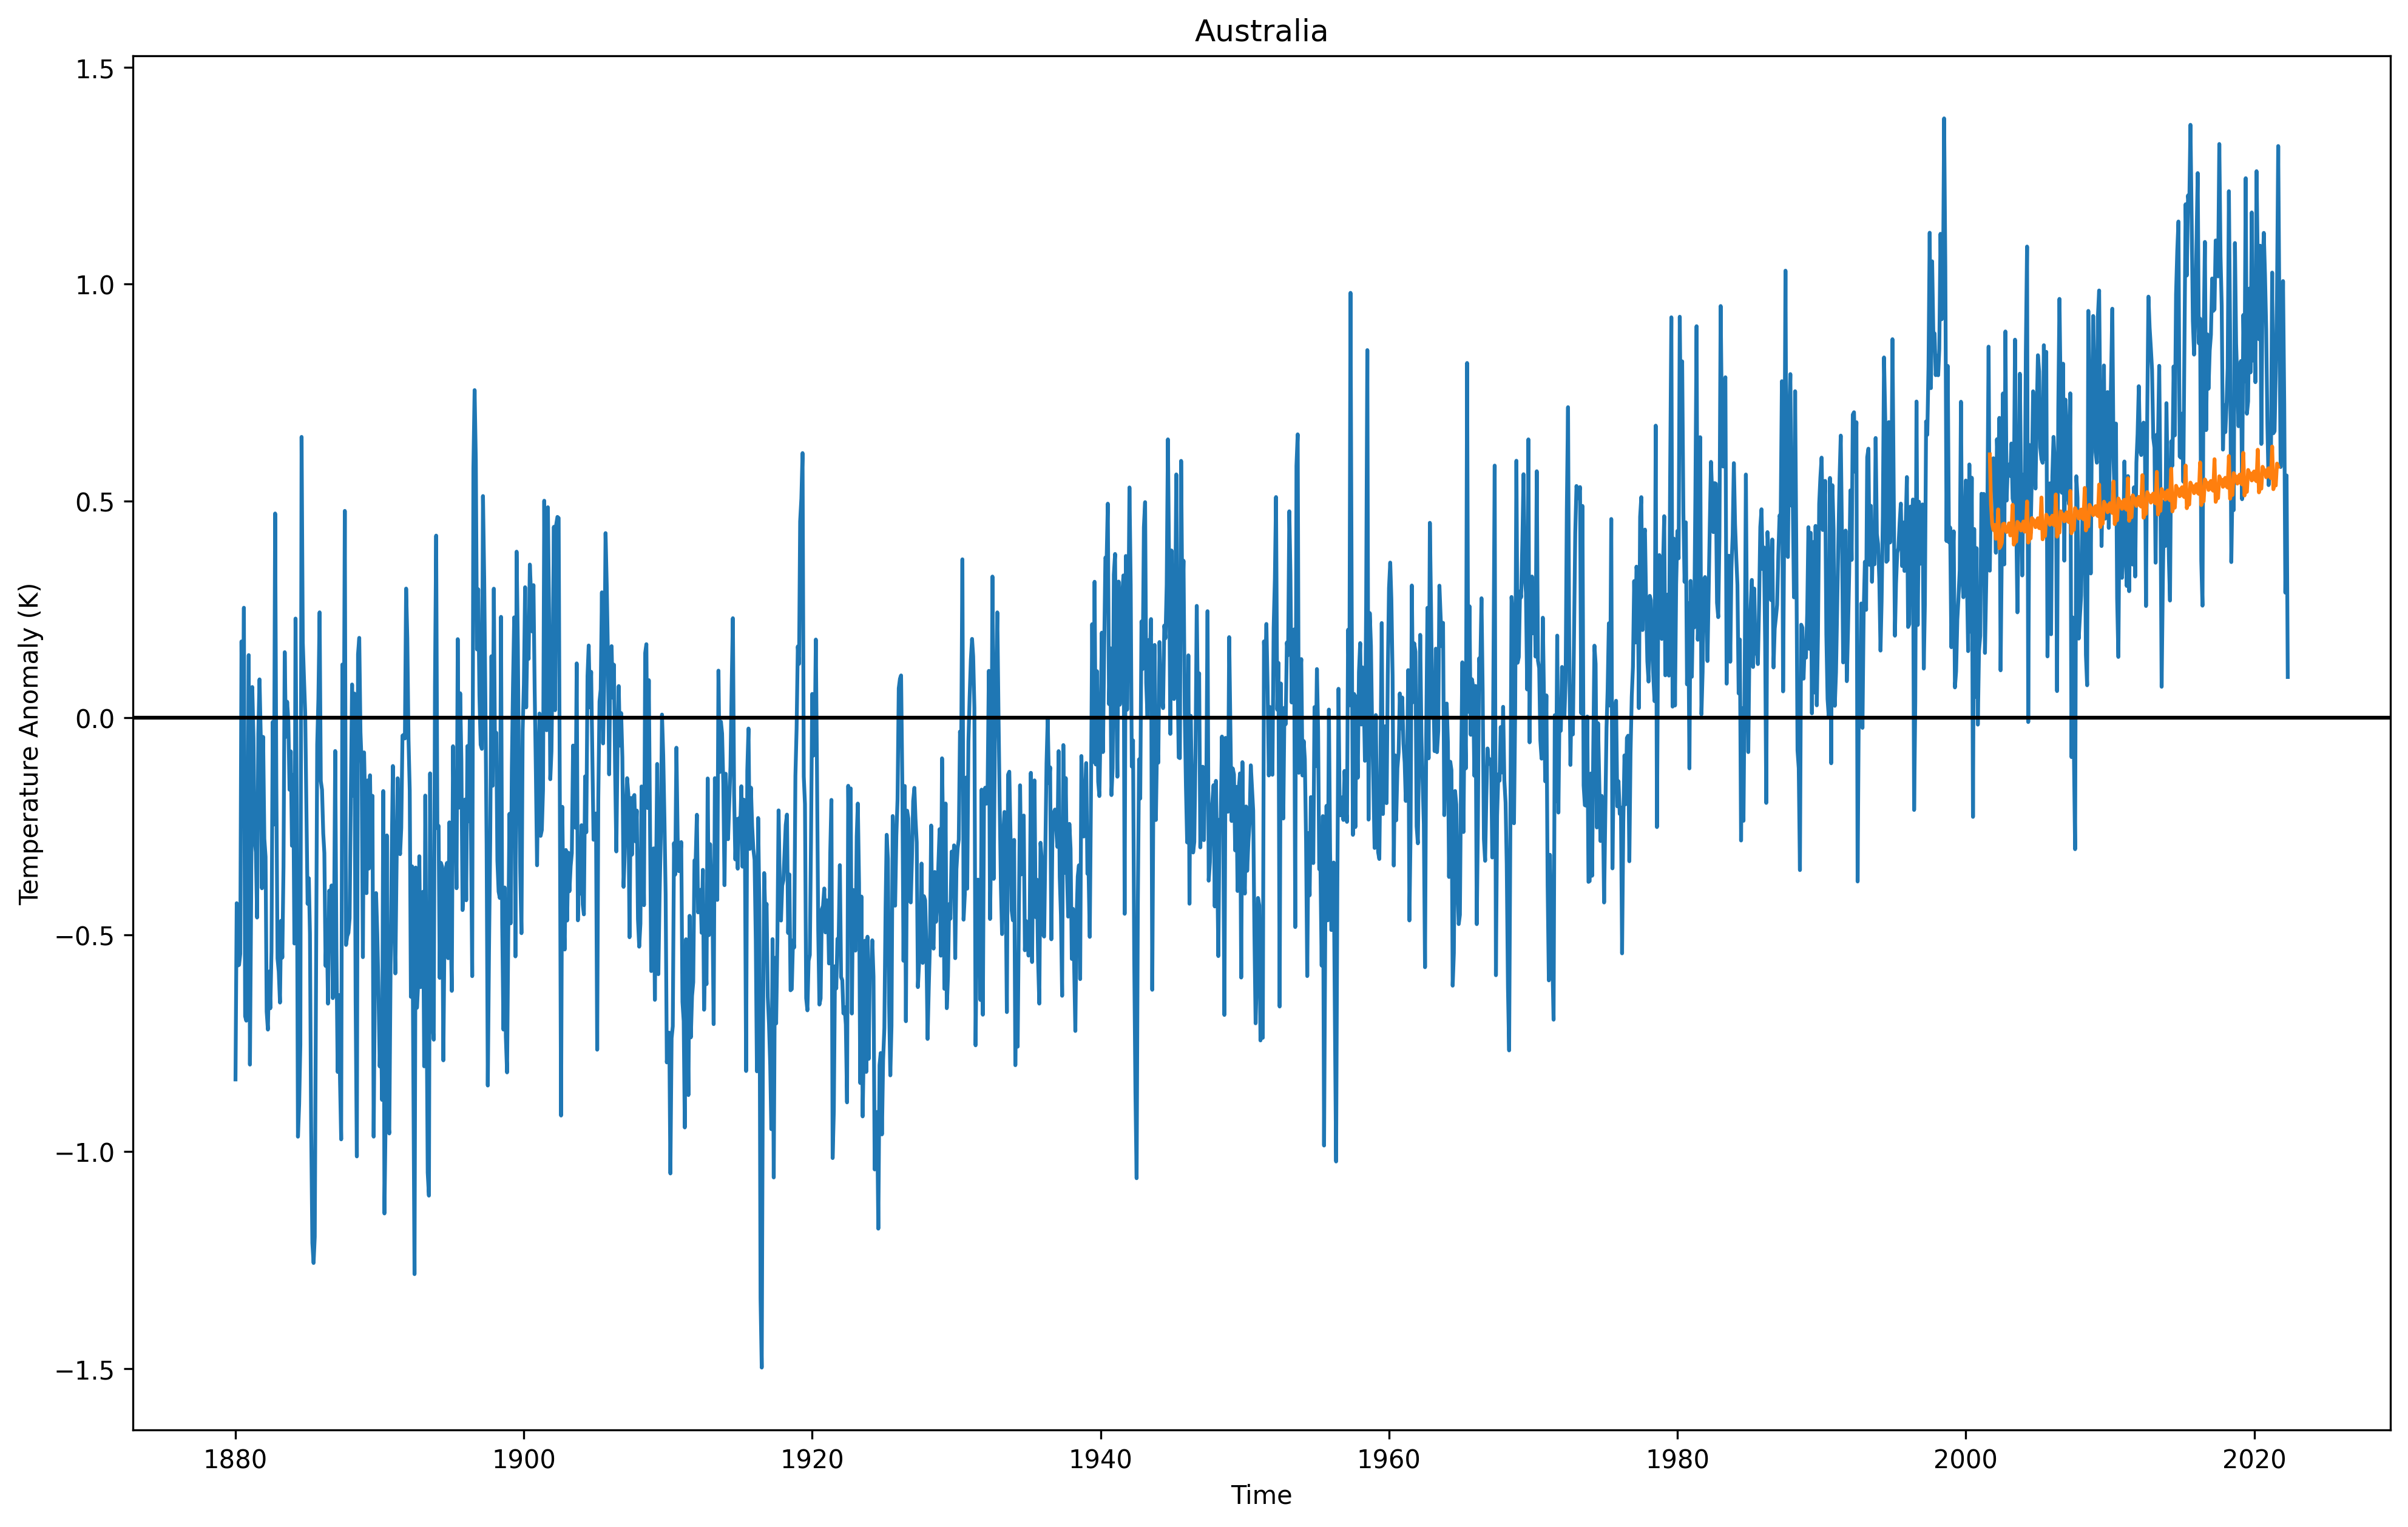

In [207]:
prediction = results.predict(start=1460,end=1700,dynamic=True)
plt.figure(figsize=(16,10))
plt.plot(mean_anomaly_pd)
plt.plot(prediction)
plt.title(region)
plt.xlabel("Time")
plt.ylabel("Temperature Anomaly (K)");
plt.axhline(y = 0, color = 'black')